# **Capstone project Coursera - Google: Providing data-driven suggestions for HR**

Author: Giovanni Simões Delsoto

# **PACE stages**


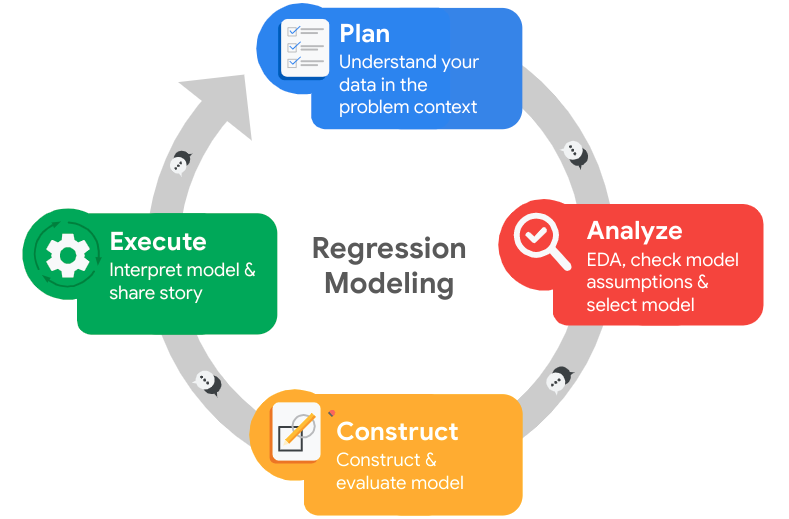

## **Pace: Plan**

### Understand the business scenario and problem

The HR department at Salifort Motors is aiming to improve employee satisfaction within the company. They have collected data from employees but are unsure how to use it effectively. As a data analytics professional, you have been asked to provide data-driven insights to help guide their initiatives. The key question is: what factors are likely to cause an employee to leave the company?

The goals of this project are to analyze the HR department's collected data and build a model to predict whether an employee is likely to leave the company.

Predicting potential employee departures could help identify contributing factors to employee turnover. This is crucial because finding, interviewing, and hiring new employees can be costly and time-consuming. Therefore, improving employee retention can benefit the company significantly.

### The HR dataset

The dataset contains 15,000 rows and 10 columns for the variables listed below. For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Import packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#Import model_selection
from sklearn.model_selection import train_test_split,GridSearchCV

#Import Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance #For classification
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


In [2]:
import os
print(os.listdir("../input"))

['hr-dataset']


### Load dataset

`Pandas` is used to read a dataset called **`HR_capstone_dataset.csv`.**

In [3]:
# A lot of warning about division by zero at the GridSearchCV and about using values on copy dataset
import warnings
warnings.filterwarnings("ignore")

# Load dataset into a dataframe
df0 = pd.read_csv("../input/hr-dataset/HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2. Data Exploration (Initial EDA and data cleaning)

- Understand the variables
- Clean your dataset (missing data, redundant data, outliers)

### Gather basic information about the data

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [5]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


The maximum and average values appear reasonable. However, it is noted that the highest workload is 310 hours. If the person takes one day off per week (25 working days per month), this would average 12.4 hours of work per day. On average, workers spend 200 hours at the company, which averages 8 hours per day with only one day of rest.

### Rename columns

In [6]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [7]:
df0.rename(columns={'Work_accident':'work_accident','Department':'department'
                    ,'last_evaluation':'last_eval','number_project':'num_project'
                   ,'average_montly_hours':'avg_montly_hours','time_spend_company':'tenure','promotion_last_5years':'promotion'},inplace=True)

df0.columns

Index(['satisfaction_level', 'last_eval', 'num_project', 'avg_montly_hours',
       'tenure', 'work_accident', 'left', 'promotion', 'department', 'salary'],
      dtype='object')

### Checking missing values

Check for any missing values in the data.

In [8]:
df0.isna().sum()

satisfaction_level    0
last_eval             0
num_project           0
avg_montly_hours      0
tenure                0
work_accident         0
left                  0
promotion             0
department            0
salary                0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [9]:
df0.duplicated(keep='first').sum()

3008

In [10]:
# Checking if there is any pattern in the duplicated data
duplicated = df0[df0.duplicated(keep='first')]

describe_dupl = duplicated.describe()
describe_all = df0.describe()
diff_describe = (describe_dupl - describe_all)/describe_all

print(f"Relative difference for the duplicated data mean values(%): \n\n{diff_describe.loc['mean']*100}")

Relative difference for the duplicated data mean values(%): 

satisfaction_level    -10.944064
last_eval              -0.323302
num_project             0.021111
avg_montly_hours        1.143692
tenure                 15.198729
work_accident         -26.664273
left                  120.623469
promotion              81.322534
Name: mean, dtype: float64


This table reveals that duplicate data has a higher percentage of employees who left the company and those who received a promotion. Now, let's examine the differences in the categorical distributions.

In [11]:
department_dup = duplicated['department'].value_counts(normalize=True)
department_all = df0['department'].value_counts(normalize=True)
department_diff = (department_dup - department_all)/department_all
print(f"Relative difference for deparment distribution(%): \n\n{department_diff*100}")

salary_dup = duplicated['salary'].value_counts(normalize=True)
salary_all = df0['salary'].value_counts(normalize=True)
salary_diff = (salary_dup - salary_all)/salary_all
print(f"\nRelative difference for deparment salary(%): \n\n{salary_diff*100}")


Relative difference for deparment distribution(%): 

department
IT              2.003161
RandD         -41.075936
accounting     -5.083445
hr             -6.885113
management     53.548527
marketing       7.514964
product_mng    19.407522
sales           8.519785
support        -8.728630
technical     -12.738531
Name: proportion, dtype: float64

Relative difference for deparment salary(%): 

salary
low       7.415509
medium   -8.333105
high     -0.433847
Name: proportion, dtype: float64


The most notable difference is that the duplicate data set contains more workers from the management department and fewer from R&D.

Overall, 20% of the data appears to be duplicated, and these duplicates do not seem to be random, as they display differences compared to the rest of the data. It would be beneficial to investigate whether these data points are truly duplicates (i.e., coming from the same worker) or are unique records with identical values. For now, we will remove them to ensure that we are not using duplicate data.

In [12]:
# Drop duplicates and save as new dataframe
df = df0.drop_duplicates(keep='first')

df.head()

,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,work_accident,left,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check outliers

To identify outliers in the data, let's create boxplots.

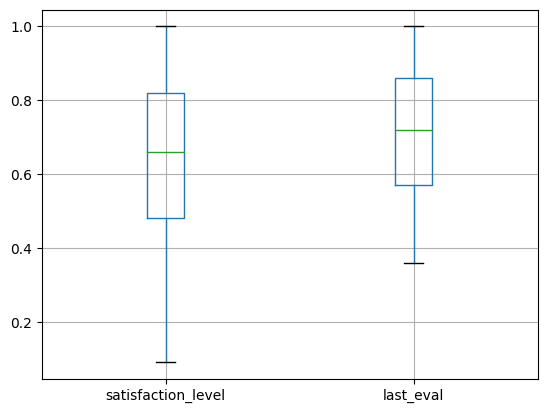

In [13]:
# Create a boxplot to check for outliers
  
df.boxplot(column = ['satisfaction_level','last_eval'])
plt.show()

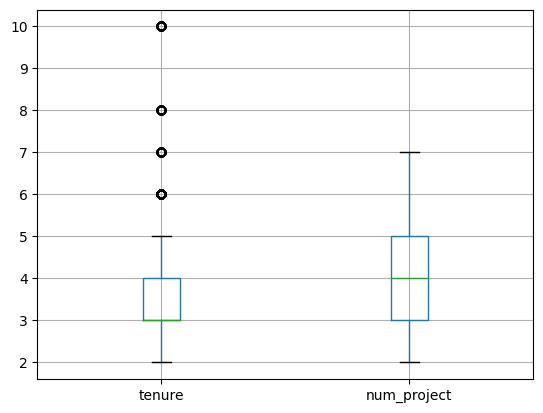

In [14]:
df.boxplot(column = ['tenure','num_project'])
plt.show()

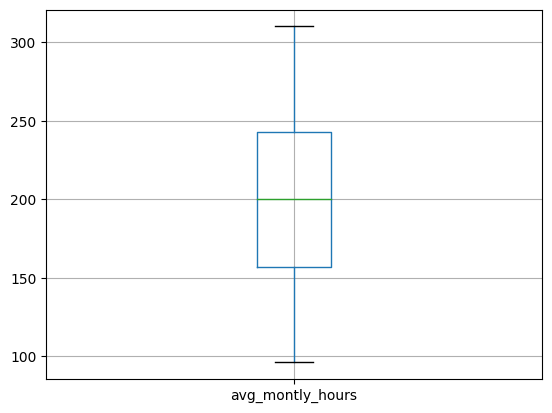

In [15]:
df.boxplot(column = ['avg_montly_hours'])
plt.show()

In [16]:
# Determine the number of rows containing outliers

q1 = df['tenure'].quantile(0.25)
q3 = df['tenure'].quantile(0.75)
iqr = q3 - q1

mask = (df['tenure'] < q1 - 1.5 * iqr) | (df['tenure'] > q3 + 1.5 *iqr)

display(df[mask].groupby(['tenure','left']).size().reset_index())

,tenure,left,0
0,6,0,433
1,6,1,109
2,7,0,94
3,8,0,81
4,10,0,107


The only variable that exhibited outliers is tenure. These outlier values do not appear to be data errors; instead, they likely reflect the rarity of workers staying at the company for more than six years. However, there are no cases of workers leaving the company after seven years of employment, which could pose challenges for fitting a logistic regression model. Therefore, I will treat tenures of seven years or more as outliers.

# pAce: Analyze Stage - EDA

## Step 2. Data Exploration

Let's begin by understanding how many employees left and what percentage of all employees this figure represents.

In [17]:
# Get numbers of people who left vs. stayed

dic_left = {0:'Stayed',1:'Left'}

df_aux = pd.DataFrame(df['left'].map(dic_left).value_counts()).rename(columns={'left':'count'})
df_aux['Percentage'] = df['left'].map(dic_left).value_counts(normalize=True)

display(df_aux)


,count,Percentage
left,,
Stayed,10000,0.833959
Left,1991,0.166041


### Data visualizations

In [18]:
# Let's check the correlation matrix for the variables
#Encode Salary for the correlation matrix

salary_dic = {'low':0,
             'medium':1,
             'high':2}
df = df.copy()
df['salary_num'] = df['salary'].map(salary_dic) 

df.head()

number_columns = ['satisfaction_level','last_eval','num_project','avg_montly_hours','tenure','work_accident','left','promotion','salary_num']

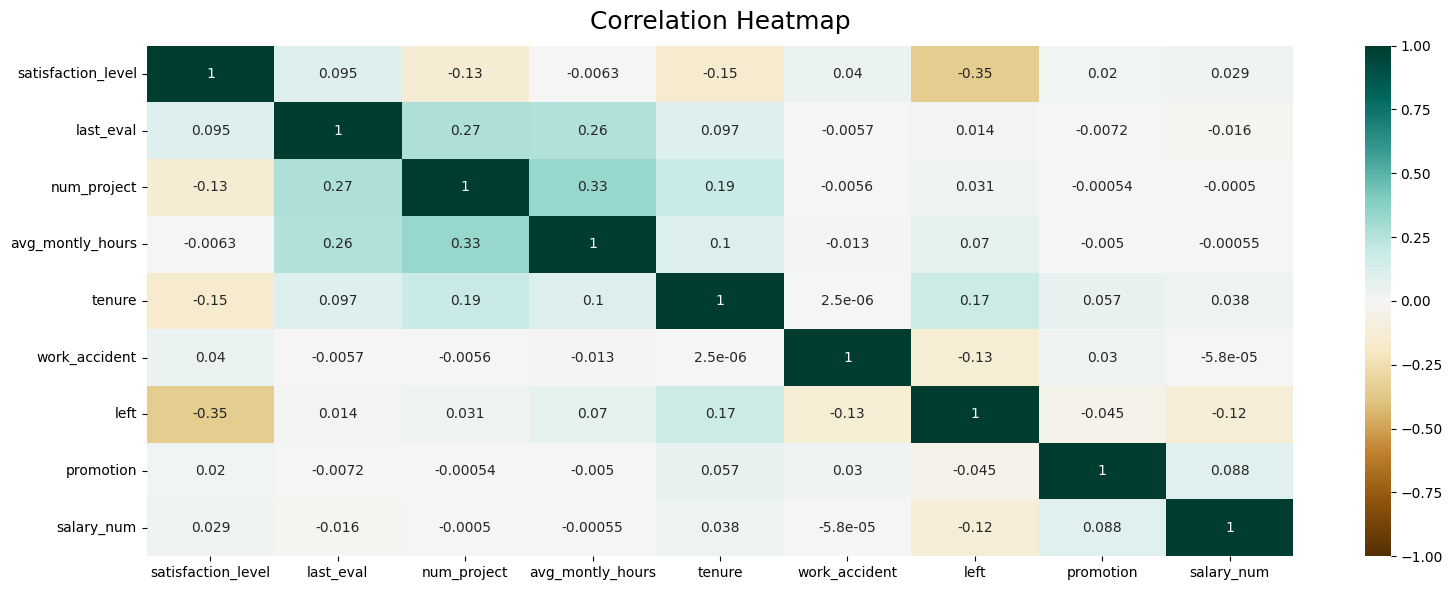

In [19]:
# Creating the correlation matrix

corr = df.drop(['department','salary'],axis=1).corr()

plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.tight_layout()

plt.show()

Notably, no factors demonstrate a strong correlation with one another. The variables that seem to most influence employee turnover are job satisfaction and tenure at the company. Workers who are more satisfied with their job appear to resign less frequently.

Now, let's examine the distribution of these variables.

<Figure size 1200x600 with 0 Axes>

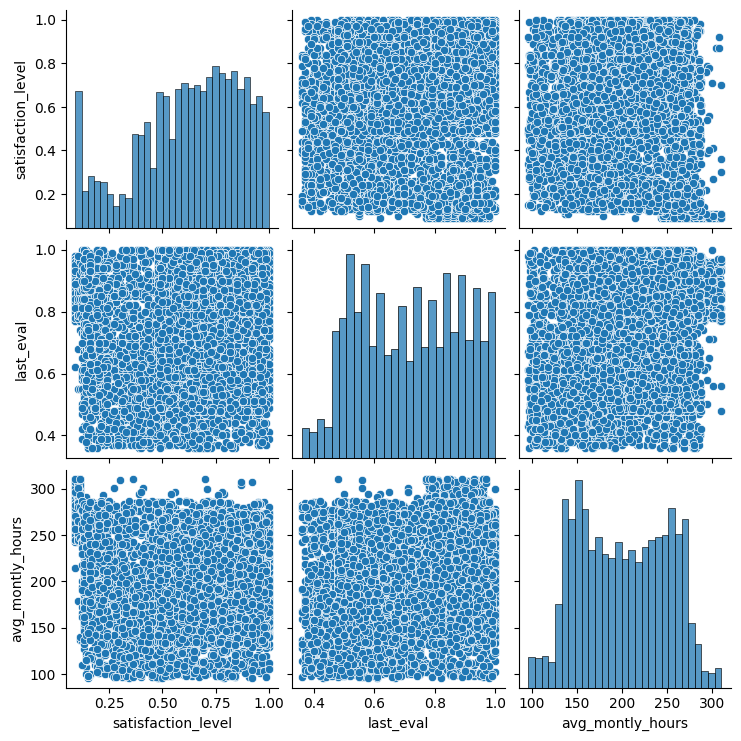

In [20]:
# Create a pairplot for the float data

plt.figure(figsize=(12, 6))
sns.pairplot(data=df[['satisfaction_level','last_eval','avg_montly_hours']])
plt.show()

Among the continuous variables, there doesn't seem to be any relationship. The variable "satisfaction_level" has a left-skewed distribution, with the majority indicating satisfaction with the company. There is also a significant number of people extremely dissatisfied. The variables related to the last evaluation and the number of monthly hours worked showed a more homogeneous distribution. 

Now, let's take a close look at each variable

## Tenure:

In [21]:
# Grouping Data by tenure
df_grouped = df[number_columns].groupby(['tenure']).mean().reset_index()
df_grouped.head()

,tenure,satisfaction_level,last_eval,num_project,avg_montly_hours,work_accident,left,promotion,salary_num
0,2,0.699165,0.717986,3.684880,199.850859,0.171821,0.010653,0.013402,0.616495
1,3,0.648988,0.684333,3.457803,190.505780,0.149711,0.168401,0.017148,0.595376
2,4,0.516090,0.754354,4.423441,215.950623,0.137656,0.246883,0.010973,0.583042
3,5,0.583183,0.791864,4.464218,218.212806,0.140301,0.453861,0.010358,0.535782
4,6,0.571107,0.736439,4.167897,208.448339,0.162362,0.201107,0.020295,0.651292


It is noted that the longer an employee stays at the company, the lower their overall satisfaction level. The largest proportion of employees who leave the company have been there for 5 years (45% of workers). However, employees who have been with the company for 6 years showed half the employee turnover, yet they also received twice as many promotions.

To better visualize this, let's examine how tenure relates to satisfaction level and the proportions of employee departures

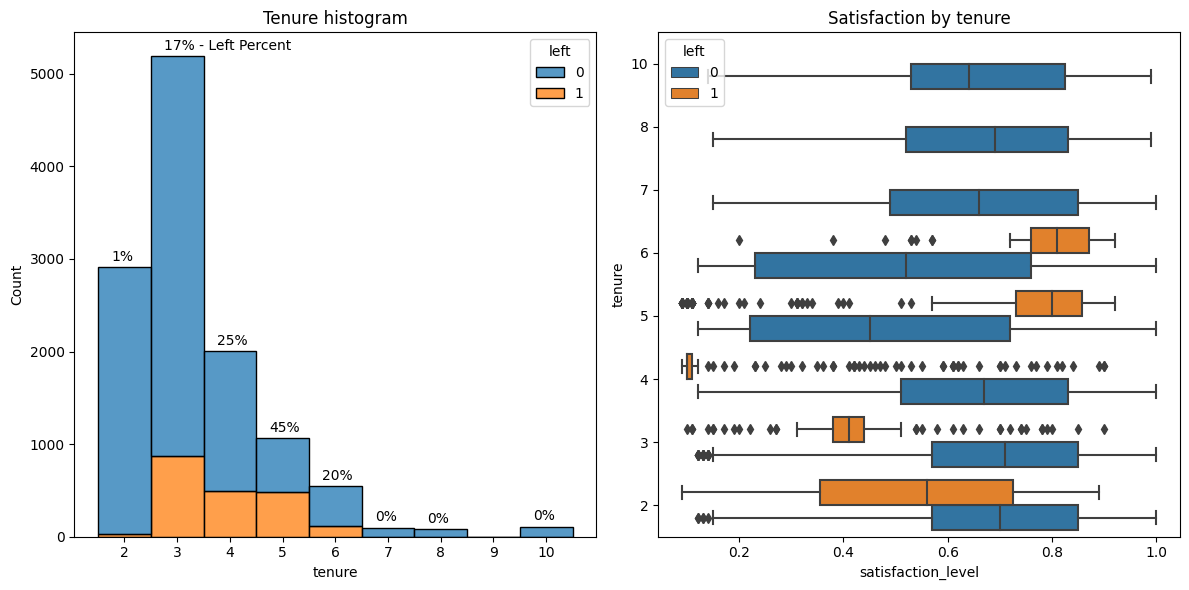

In [22]:
#Plotting tenure

fig, ax = plt.subplots(1,2, figsize=(12,6))

plots = sns.histplot(data = df, x='tenure',hue='left',multiple = 'stack',discrete=True, ax=ax[0])
ax[0].set_xticks([2,3,4,5,6,7,8,9,10])
ax[0].set_title('Tenure histogram')
count = 0
for tenur in df['tenure'].unique():
    
    
    if tenur == 3:
        plots.annotate(f"{len( df[(df['tenure']==tenur) & (df['left']==1) ])/len(df[df['tenure']==tenur])*100:.0f}% - Left Percent", 
                   (tenur-0.25, len(df[df['tenure']==tenur])-50),
                   size=10, xytext=(0, 8),
                    textcoords='offset points',
                    color = 'black')
        continue
        
    plots.annotate(f"{len( df[(df['tenure']==tenur) & (df['left']==1) ])/len(df[df['tenure']==tenur])*100:.0f}%", 
                   (tenur-0.25, len(df[df['tenure']==tenur])-50),
                   size=10, xytext=(0, 8),
                    textcoords='offset points',
                    color = 'black')
    
sns.boxplot(data=df, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Satisfaction by tenure')
ax[1].legend(title='left',loc='upper left')

plt.tight_layout()

plt.show()

As seen in the table, the figure on the left shows that the highest proportion of departures occurred for employees who have been with the company for 5 years, decreasing to zero for those with more than 7 years of tenure.

The figure on the right reveals some interesting points:

   - From 2 to 4 years, the satisfaction level of those who left decreased, suggesting they departed due to growing dissatisfaction.
   - From 2 to 4 years, the satisfaction level of those who stayed remained stable.
   - For employees with 5 and 6 years of tenure, those who left were quite satisfied. It's worth investigating the reasons behind this.
   - For employees with 5 and 6 years of tenure, those who stayed displayed greater satisfaction variance, though with a lower average than other years.
   - For those with more than 7 years of tenure, satisfaction increases and no one left the company.
   - Employees with 4 years of tenure who left were extremely dissatisfied with the company. This is mainly due to the high number of projects this cohort was assigned to (as will be shown in the following figures).

## Number of projects and Average monthly hours

In [23]:
#Groupdata by number of project
df_grouped = df[number_columns].groupby(['num_project']).mean().reset_index()
df_grouped.head()

,num_project,satisfaction_level,last_eval,avg_montly_hours,tenure,work_accident,left,promotion,salary_num
0,2,0.499071,0.584640,164.812263,3.186473,0.111252,0.541719,0.012010,0.522124
1,3,0.689418,0.717415,197.337784,3.144602,0.175852,0.010795,0.017614,0.645170
2,4,0.694280,0.735682,203.872456,3.300407,0.160651,0.064315,0.020624,0.607056
3,5,0.671155,0.750072,209.125392,3.604120,0.156740,0.153605,0.014778,0.621585
4,6,0.314673,0.765654,230.392252,4.154964,0.134383,0.449153,0.015738,0.549637


Employees involved in many projects (6) displayed higher dissatisfaction and had one of the highest proportions of departures, while also working more hours per week. This group had the highest performance evaluations but one of the lowest compensation levels. Another notable group consists of those contributing to only two projects. They have a low satisfaction level (average of 0.5) and the lowest performance evaluations. They also work the fewest monthly hours.

There appears to be a trend where employees who have been with the company longer are assigned more projects (starting from 3), and they also have a higher probability of leaving. It would be valuable to investigate how these project assignments are managed to determine whether the increase in departures is caused by these factors.

Let's examine the average number of projects per year of employment to see if there is any correlation.

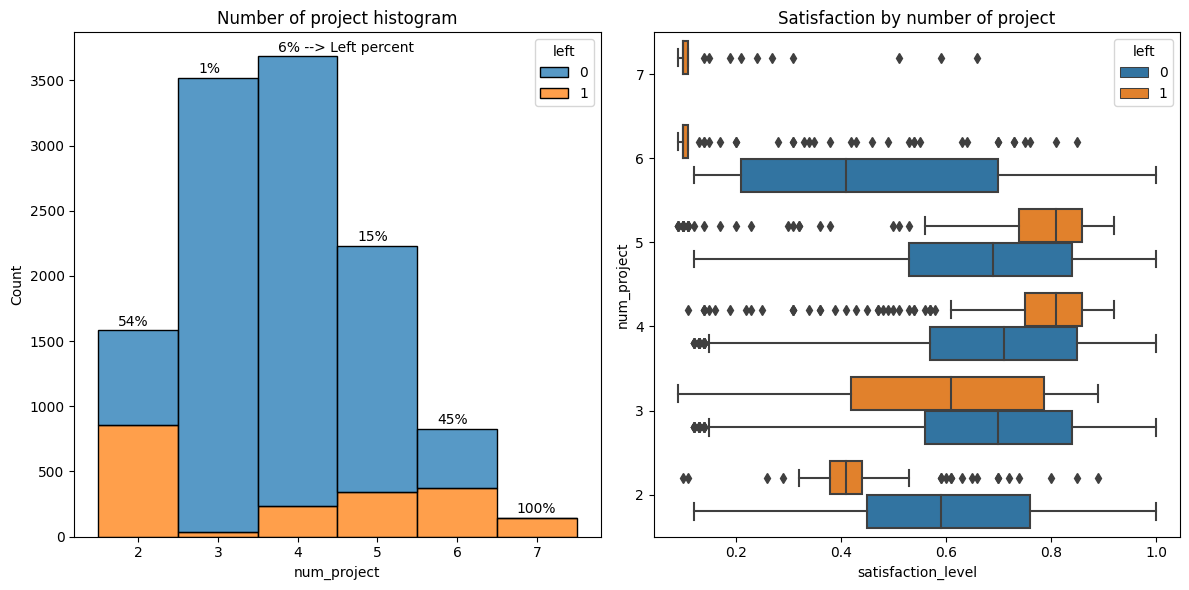

In [24]:
#Plotting tenure

fig, ax = plt.subplots(1,2, figsize=(12,6))


plots = sns.histplot(data = df, x='num_project',hue='left',multiple = 'stack',discrete=True, ax=ax[0])
ax[0].set_xticks([2,3,4,5,6,7])
ax[0].set_title('Number of project histogram')

for num_proj in df['num_project'].unique():
    
    if num_proj == 4:
        plots.annotate(f"{len( df[   (df['num_project']==num_proj) & (df['left']==1)   ] )/len(df[df['num_project']==num_proj])*100:.0f}% --> Left percent", 
                   (num_proj-0.25, len(df[df['num_project']==num_proj])-50),
                   size=10, xytext=(0, 8),
                    textcoords='offset points',
                    color = 'black')
        
        continue
    plots.annotate(f"{len( df[   (df['num_project']==num_proj) & (df['left']==1)   ] )/len(df[df['num_project']==num_proj])*100:.0f}%", 
                   (num_proj-0.25, len(df[df['num_project']==num_proj])-50),
                   size=10, xytext=(0, 8),
                    textcoords='offset points',
                    color = 'black')
    

sns.boxplot(data=df, x='satisfaction_level', y='num_project', hue='left', orient="h", ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Satisfaction by number of project')
ax[1].legend(title='left',loc='upper right')
    
plt.tight_layout()

plt.show()

- Employees with only two projects have a high rate of leaving the company and also exhibit lower satisfaction levels.
- The lowest turnover rates are found in employees with 3 or 4 projects. The satisfaction levels of those who stayed in the company are similar for both project counts.
- For 4 and 5 projects, satisfaction levels were similar, but there was a higher rate of departures for employees with 5 projects, indicating other factors influencing their exit.
- It is observed that for 6 and 7 projects, there is a drastic reduction in employee satisfaction, leading to a significant increase in departures (100% for employees with 7 projects).
- Four projects seem to be the optimal number that minimizes employee turnover and maximizes satisfaction levels.

Let's explore how these high numbers of projects are distributed in relation to tenure.

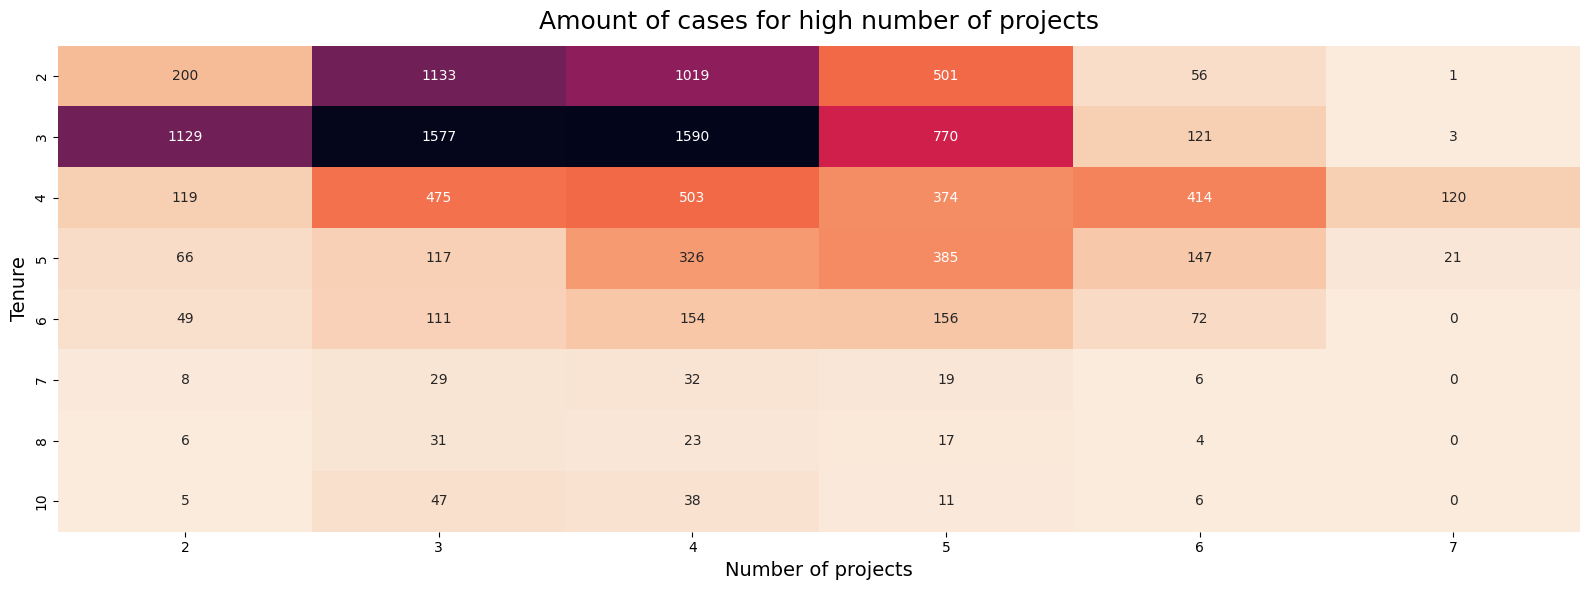

In [25]:
df_tenure_project = df.groupby(['tenure','num_project']).size()

#Create an dataframe with tenure as index and num_project as columns

index = df['tenure'].sort_values().unique()
columns = df['num_project'].sort_values().unique()

df_count = pd.DataFrame(0,index = index, columns = columns)

index_list = df_tenure_project.index

for ind in index:
    for col in columns:
        if (ind,col) in index_list:
            df_count.loc[ind,col] = df_tenure_project.loc[ind,col]

plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df_count.loc[:,:], annot=True, cmap="rocket_r",fmt=".0f",cbar=False)
heatmap.set_title('Amount of cases for high number of projects', fontdict={'fontsize':18}, pad=12);
heatmap.set_xlabel('Number of projects',fontsize = 14)
heatmap.set_ylabel('Tenure',fontsize = 14)
plt.tight_layout()

plt.show()

- We can see that the highest number of projects is concentrated among employees who have been with the company for 4 years. This explains the significant dissatisfaction observed previously.

- Employees who have been with the company for more than 7 years mostly participate in 3 to 4 projects, similar to those who have been with the company for 2 or 3 years. This differs from those who have been with the company for 5 or 6 years. This may explain the increased dissatisfaction observed in these groups.

Now, let's examine the impact of the number of projects on average monthly working hours and whether this is correlated with higher salaries.

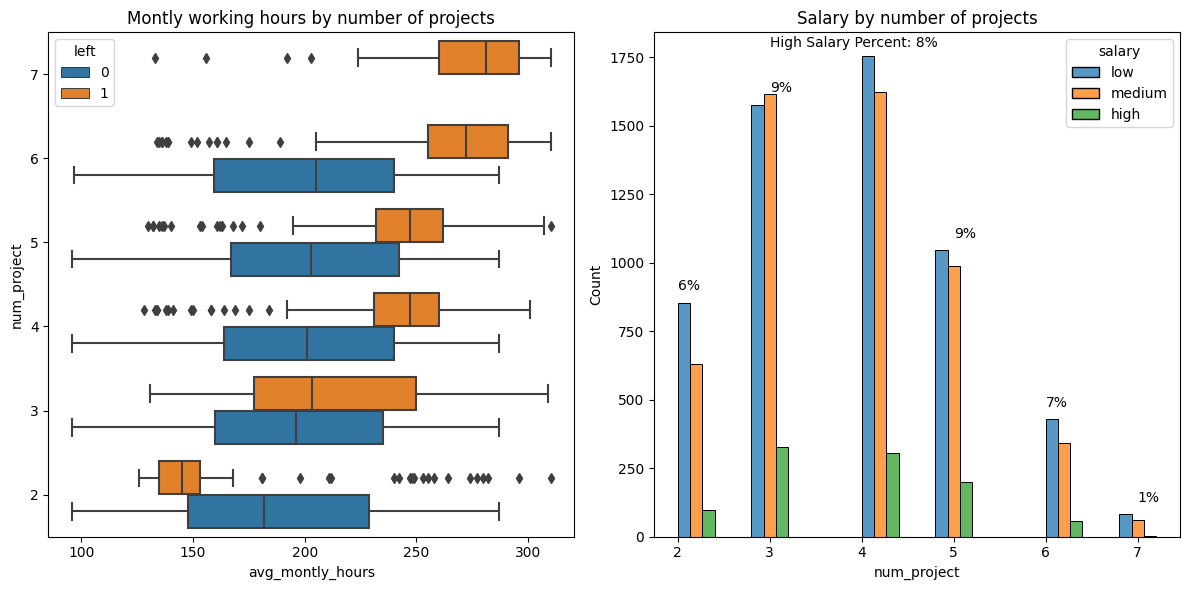

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
    
sns.boxplot(data=df, x='avg_montly_hours', y='num_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Montly working hours by number of projects')
ax[0].legend(title='left',loc='upper left')


sns.histplot(data=df, x='num_project', hue='salary', ax=ax[1], multiple='dodge',binwidth = 0.40)
ax[1].set_title('Salary by number of projects')
for num_proj in df['num_project'].unique():
    
    
    if num_proj == 4:
        ax[1].annotate(f"High Salary Percent: {len(  df[   (df['num_project']==num_proj)  &  (df['salary']=='high')]  ) /len(df[df['num_project']==num_proj])*100:.0f}%", 
                   (num_proj-1, len(  df[   (df['num_project']==num_proj)  &  (df['salary']=='low')]  ) -5),
                   size=10, xytext=(0, 8),
                    textcoords='offset points',
                    color = 'black')
        continue
    
    
    ax[1].annotate(f"{len(  df[   (df['num_project']==num_proj)  &  (df['salary']=='high')]  ) /len(df[df['num_project']==num_proj])*100:.0f}%", 
                   (num_proj, len(  df[   (df['num_project']==num_proj)  &  (df['salary']=='low')]  ) +5),
                   size=10, xytext=(0, 8),
                    textcoords='offset points',
                    color = 'black')
    
plt.tight_layout()
    

plt.show()


Here are some insights from these images:

- The groups with the highest salaries are those with 3 to 5 projects. Only 1% of employees with 7 projects earn high salaries.
- Among employees who left the company, the data shows that the more projects they handled, the higher their workload. This trend is not observed among employees who stayed. The graph suggests that the main factor influencing departures is not the number of projects an employee handles, but the time they spent working.
- For employees with 2 projects, those who left had a lower workload, with an average significantly below the others.
- When combined with previous satisfaction graphs, it is evident that employees with 6 and 7 projects worked longer hours and were more dissatisfied.

## Average Montly Hours
The images above demonstrate that the amount of time worked correlates with the level of satisfaction and with employee turnover. Now, let's investigate this variable further.

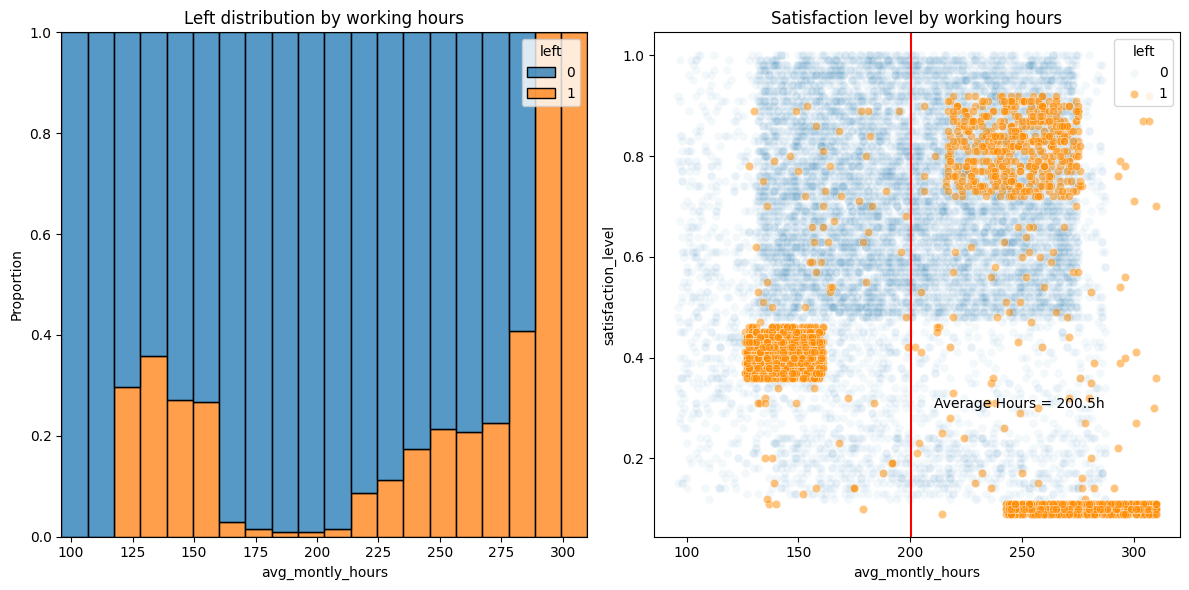

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.histplot(data=df, x='avg_montly_hours', hue='left', multiple='fill',bins=20, stat = 'proportion',ax = ax[0])

sns.scatterplot(data=df[df['left']==0], x='avg_montly_hours', y='satisfaction_level', ax=ax[1],alpha=0.05,)
sns.scatterplot(data=df[df['left']==1], x='avg_montly_hours', y='satisfaction_level', ax=ax[1],alpha=0.5,color='darkorange')
ax[1].axvline(x=df['avg_montly_hours'].mean(),color='red')
ax[1].annotate(f"Average Hours = {df['avg_montly_hours'].mean():.1f}h",(df['avg_montly_hours'].mean()+10,0.3))

ax[1].legend(['0','1'],title = 'left')

ax[0].set_title('Left distribution by working hours')
ax[1].set_title('Satisfaction level by working hours')
plt.tight_layout()

plt.show()

These graphs provide significant insights into employee turnover. The left graph shows the proportion of employees leaving the company based on their monthly working hours, while the right graph correlates this data with job satisfaction.

- The lowest proportion of departures is observed around 200 hours per month. Very low values (around 125) or very high values (above 225 hours, equivalent to 9 hours worked per day over 25 days in a month, assuming 1 day off per week) are associated with higher rates of departure.
- Above 275 hours (equivalent to 11 hours worked per day), the departure rate is extremely high. This may be due to overworking.
- There are three clusters of employees leaving the company. The first cluster is associated with below-average job satisfaction and few monthly working hours (around 150 hours). The second cluster is associated with employees who work many hours (over 250 hours) and are very dissatisfied. The last cluster is associated with employees who work more than average hours but are satisfied.

Let's also see if the number of hours worked is associated with higher performance evaluations and salaries.

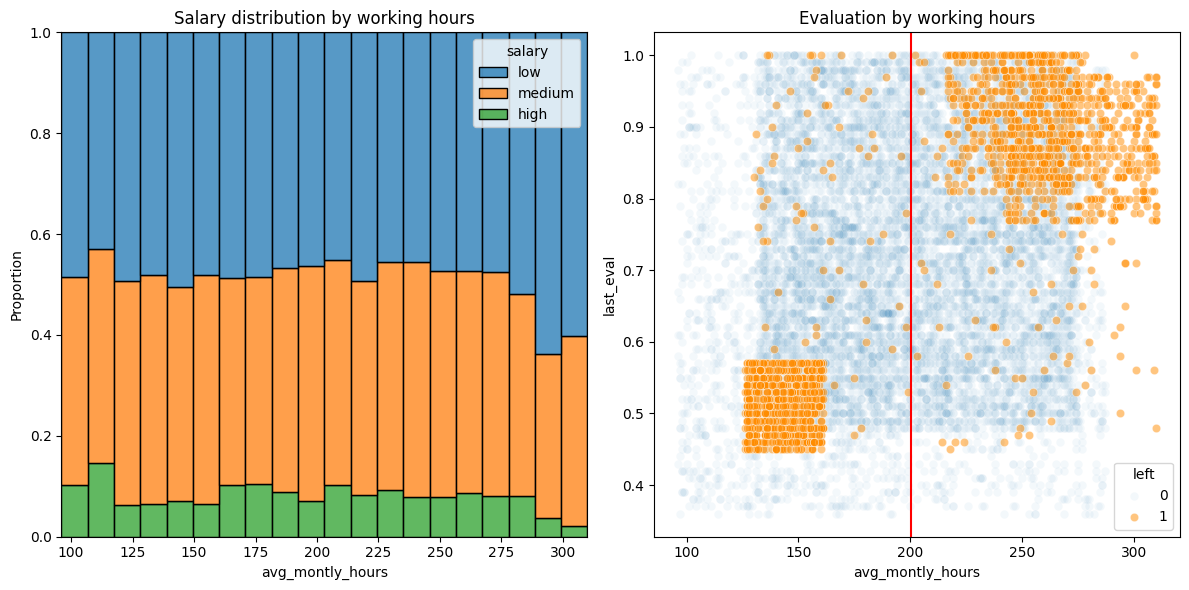

In [28]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.histplot(data=df, x='avg_montly_hours', hue='salary', multiple='fill',bins=20, stat = 'proportion',ax = ax[0])

sns.scatterplot(data=df[df['left']==0], x='avg_montly_hours', y='last_eval', ax=ax[1],alpha=0.05,)
sns.scatterplot(data=df[df['left']==1], x='avg_montly_hours', y='last_eval', ax=ax[1],alpha=0.5,color='darkorange')
ax[1].axvline(x=df['avg_montly_hours'].mean(),color='red')
ax[1].annotate(f"Average Hours = {df['avg_montly_hours'].mean():.1f}h",(df['avg_montly_hours'].mean()+10,0.3))

ax[1].legend(['0','1'],title = 'left')

ax[0].set_title('Salary distribution by working hours')
ax[1].set_title('Evaluation by working hours')
plt.tight_layout()


plt.show()

- We can identify two groups of employees who left the company. The first group consists of those with a low number of hours per month and significantly below-average performance evaluations. The second group comprises those with high workloads and excellent performance evaluations.

- Higher workloads are not associated with higher salaries. One possible explanation for the departure of satisfied employees from the company is the lack of better salaries. As these employees are valuable assets, it is possible that they found better conditions in other companies

In [29]:
#Group data by salary

df_grouped = df[number_columns].groupby(['salary_num']).mean().reset_index()

print(f"Salary count: \n{df['salary_num'].value_counts()}")
df_grouped.head()

Salary count: 
salary_num
0    5740
1    5261
2     990
Name: count, dtype: int64


,salary_num,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,work_accident,left,promotion
0,0,0.622655,0.718512,3.801742,200.439199,3.319686,0.154878,0.204530,0.006620
1,1,0.634723,0.716539,3.806121,200.587341,3.389850,0.153013,0.146170,0.022999
2,2,0.643343,0.706838,3.791919,200.067677,3.493939,0.157576,0.048485,0.044444


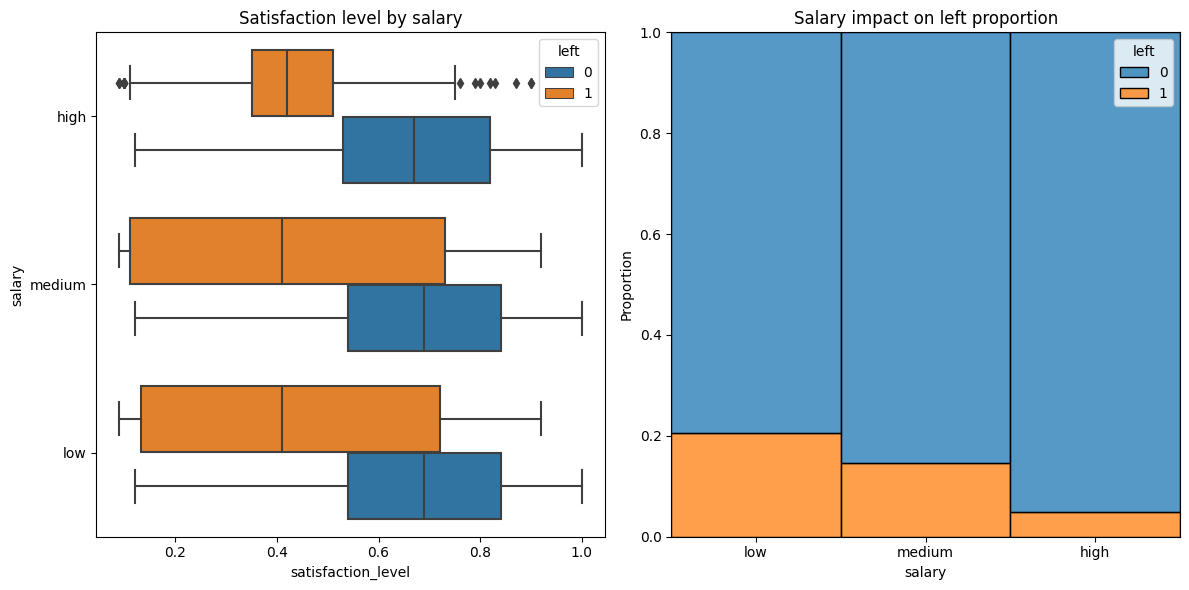

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
    
sns.boxplot(data=df, x='satisfaction_level', y='salary', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction level by salary')
ax[0].legend(title='left',loc='upper right')


sns.histplot(data=df, x='salary', hue='left', multiple='fill',bins=20, stat = 'proportion',ax = ax[1])
ax[1].set_title('Salary impact on left proportion')

plt.tight_layout()
    

plt.show()


- Salary does not appear to affect the level of worker satisfaction.

- However, salary significantly impacts the percentage of employees leaving the company. High salaries are associated with a 5% departure rate, while lower salaries can reach up to 20%.

In [31]:
#Group data by department

df_grouped = df[number_columns + ['department']].groupby('department').mean().reset_index()
print(f"Department count: \n{df['department'].value_counts()}")


df_grouped.head(10)

Department count: 
department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64


,department,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,work_accident,left,promotion,salary_num
0,IT,0.634016,0.715051,3.797131,200.638320,3.350410,0.142418,0.161885,0.002049,0.585041
1,RandD,0.627176,0.712983,3.850144,201.291066,3.319885,0.171470,0.122478,0.030259,0.603746
2,accounting,0.607939,0.721900,3.834138,200.877617,3.404187,0.140097,0.175523,0.016103,0.624799
3,hr,0.621947,0.715691,3.675541,199.371048,3.256240,0.133111,0.188020,0.018303,0.570715
4,management,0.631995,0.726307,3.837156,201.529817,3.981651,0.165138,0.119266,0.082569,0.974771
5,marketing,0.634770,0.718440,3.720654,199.487370,3.421991,0.160475,0.166419,0.040119,0.631501
6,product_mng,0.629825,0.713790,3.794461,198.893586,3.341108,0.158892,0.160350,0.000000,0.575802
7,sales,0.631349,0.710398,3.777092,200.242050,3.380673,0.153751,0.169805,0.017907,0.593702
8,support,0.634822,0.722998,3.820977,200.627128,3.292696,0.164195,0.171334,0.008786,0.593081
9,technical,0.627937,0.719791,3.859180,201.115419,3.309269,0.151070,0.173797,0.009804,0.566845


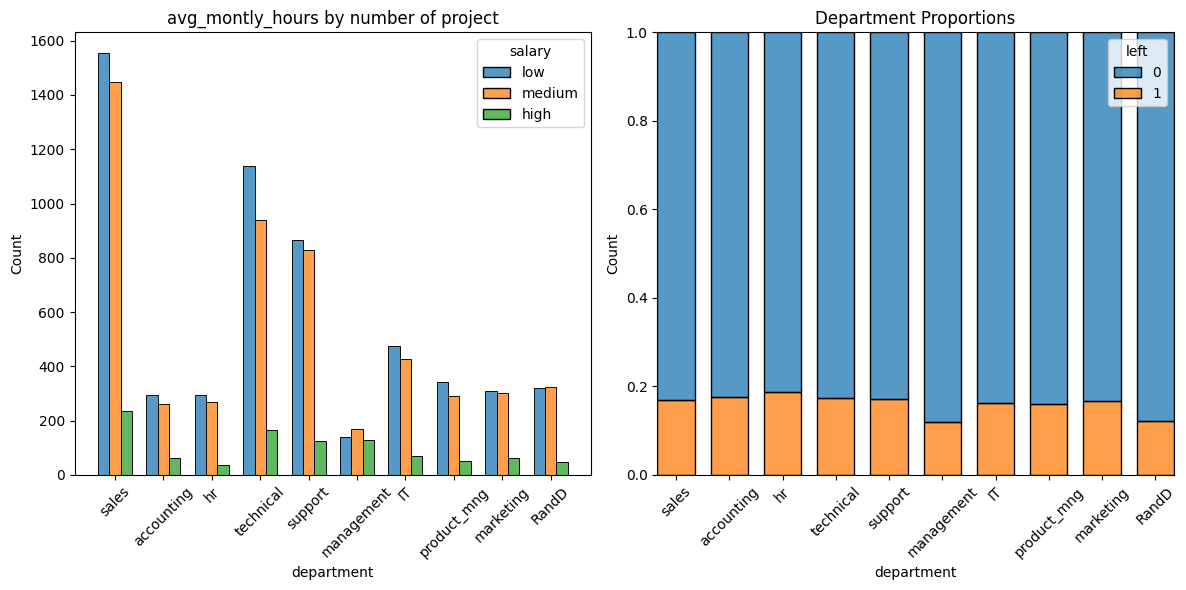

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
    
sns.histplot(data=df, x='department', hue='salary', ax=ax[0], multiple='dodge', shrink = 0.7)
ax[0].set_title('avg_montly_hours by number of project')
ax[0].tick_params(axis='x',labelrotation=45)


sns.histplot(data=df, x='department', hue='left', ax=ax[1], multiple='fill', shrink = 0.7)
ax[1].set_title('Department Proportions')
ax[1].tick_params(axis='x',labelrotation=45)
plt.tight_layout()

plt.show()

Insights from the table and graphs:
- The management department had the lowest percentage of employee turnover, while the HR department had the highest.
- Proportionally, the management sector has the highest average salaries.
- The management sector has the lowest dismissal rate, longest tenure at the company, and the highest percentage of promotions in the last 5 years.
- The HR and accounting departments had the highest employee turnover rates. Additionally, the proportion of employees promoted in these sectors is four times lower than that of the management sector.

In [33]:
#Group data by promotion

df_grouped = df[number_columns].groupby(['promotion']).mean().reset_index()
print(f"Promotion count: \n{df['promotion'].value_counts()}")

df_grouped.head()

Promotion count: 
promotion
0    11788
1      203
Name: count, dtype: int64


,promotion,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,work_accident,left,salary_num
0,0,0.629032,0.716842,3.802935,200.505260,3.354937,0.152867,0.168222,0.596539
1,1,0.666010,0.707438,3.798030,198.630542,3.940887,0.236453,0.039409,1.029557


Very few people received promotions within the group, but a significant reduction in the percentage of departures can be observed, which may be attributed to the higher salaries in this group.

## Key Insights from EDA:

- Higher turnover rates are associated with employees who have 4 to 6 years of experience in the company. Specifically, employees with 4 years of experience, who also tend to have a lot of projects, left the company extremely dissatisfied.
- There is a balance between workload and job satisfaction. Employees with an appropriate workload tend to be more satisfied and less likely to leave the company, while those with either too few (2) or too many projects (6 or 7) are more likely to leave and are less satisfied with their job.
- High workloads lead to dissatisfaction and increased turnover rates. They also are not associated with higher salaries.
- There is a group of satisfied employees with a suitable workload who are leaving the company. This suggests they may be seeking better salaries elsewhere.
- Salaries do not significantly affect employee satisfaction levels but do impact turnover rates.
- The management department not only have lower turnover rates but also have the highest mean tenure at the company and receive more promotions, indicating higher job satisfaction and career growth opportunities in this department.
- Employees who were promoted in the last 5 years have lower turnover rates, suggesting that career advancement opportunities can significantly impact employee retention.

# Statistical Tests

Let's evaluate whether the impact of other variables on turnover is statistically significant.

## Categorical Data: Chi-test for independence

The variables "salary," "department," "num_project," "work_accident," and "tenure" are categorical. We will use the chi-square test to assess whether the distribution of employee turnover is statistically significant.

In [34]:
## SALARY

left = df[df['left'] == 1]
stay = df[df['left'] == 0]

# Create contingency table

left_salary = left.groupby('salary_num').size()
stay_salary = stay.groupby('salary_num').size()

contingency_table = np.array([
    list(left_salary),
    list(stay_salary)
])

# Run the chi-square test
chi2, pval, degrees_of_freedom, expected_table = chi2_contingency(contingency_table)

# Interpret the results
print("Salary:\n")
if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in salary distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in salary distribution between leavers and stayers.")

Salary:

There is a statistically significant difference (p-value =8.98E-39) in salary distribution between leavers and stayers.


In [35]:
## Department

# Create contingency table

left_department = left.groupby('department').size()
stay_department = stay.groupby('department').size()

contingency_table = np.array([
    list(left_department),
    list(stay_department)
])

# Run the chi-square test
chi2, pval, degrees_of_freedom, expected_table = chi2_contingency(contingency_table)

# Interpret the results
print("Department:\n")
if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in department distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in department distribution between leavers and stayers.")

Department:

There is a statistically significant difference (p-value =1.33E-02) in department distribution between leavers and stayers.


In [36]:
## Tenure

# Create contingency table

left_tenure = left.groupby('tenure').size()
stay_tenure = stay[stay['tenure']<7].groupby('tenure').size()

contingency_table = np.array([
    list(left_tenure),
    list(stay_tenure)
])

# Run the chi-square test
chi2, pval, degrees_of_freedom, expected_table = chi2_contingency(contingency_table)

# Interpret the results
print("Tenure:\n")
if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in tenure distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in tenure distribution between leavers and stayers.")

Tenure:

There is a statistically significant difference (p-value =2.31E-262) in tenure distribution between leavers and stayers.


In [37]:
## Project

# Create contingency table

left_project = left[left['num_project']<7].groupby('num_project').size()
stay_project = stay.groupby('num_project').size()


contingency_table = np.array([
    list(left_project),
    list(stay_project)
])

# Run the chi-square test
chi2, pval, degrees_of_freedom, expected_table = chi2_contingency(contingency_table)

# Interpret the results
print("Number of project:\n")
if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval}) in number of project distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval}) in number of project distribution between leavers and stayers.")

Number of project:

There is a statistically significant difference (p-value =0.0) in number of project distribution between leavers and stayers.


In [38]:
## Accident

# Create contingency table

left_accident = left.groupby('work_accident').size()
stay_accident = stay.groupby('work_accident').size()


contingency_table = np.array([
    list(left_accident),
    list(stay_accident)
])

# Run the chi-square test
chi2, pval, degrees_of_freedom, expected_table = chi2_contingency(contingency_table)

# Interpret the results
print("Work Accident:\n")
if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in work accident distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in work accident distribution between leavers and stayers.")

Work Accident:

There is a statistically significant difference (p-value =9.91E-43) in work accident distribution between leavers and stayers.


### Continuous variables: T-test

The variables "satisfaction_level," "last_eval," and "avg_montly_hours" are continuous. Since we only have two groups (those who stayed and those who left), we can use the t-test to assess whether the differences are statistically significant.

In [39]:
#satisfaction_level

a_group = left['satisfaction_level']
b_group = stay['satisfaction_level']

statisc, pval = stats.ttest_ind(a_group , b_group, equal_var = True, alternative='two-sided')
print("Satisfaction Level:\n")
if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in satisfaction level distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in satisfaction level distribution between leavers and stayers.")


Satisfaction Level:

There is a statistically significant difference (p-value =0.00E+00) in satisfaction level distribution between leavers and stayers.


In [40]:
#last_eval

a_group = left['last_eval']
b_group = stay['last_eval']

statisc, pval = stats.ttest_ind(a_group , b_group, equal_var = True, alternative='two-sided')
print("Evaluation:\n")

if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in evaluation distribution between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in evaluation distribution between leavers and stayers.")


Evaluation:

There is no statistically significant difference (p-value =1.39E-01) in evaluation distribution between leavers and stayers.


In [41]:
#avg_montly_hours

a_group = left['avg_montly_hours']
b_group = stay['avg_montly_hours']

statisc, pval = stats.ttest_ind(a_group , b_group, equal_var = True, alternative='two-sided')
print("Montly hours:\n")

if pval < 0.05: 
    print(f"There is a statistically significant difference (p-value ={pval:.2E}) in montly hours between leavers and stayers.")
else:
    print(f"There is no statistically significant difference (p-value ={pval:.2E}) in montly hours distribution between leavers and stayers.")


Montly hours:

There is a statistically significant difference (p-value =1.17E-14) in montly hours between leavers and stayers.


### Summary:
Only the "last_eval" variable did not show a statistically significant difference in the turnover of workers.

## K-means for Analysis

From the presented graphs, we can see that there are groups of employees leaving the company for different reasons. Using the K-means clustering method, let's try to group the employees who left into clusters. We will use these clusters for further analysis of the reasons for leaving and to create models.

In [42]:
X = df[df['left']==1].drop(['work_accident','department','salary','left'],axis = 1)
X.head()

,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,promotion,salary_num
0,0.38,0.53,2,157,3,0,0
1,0.80,0.86,5,262,6,0,1
2,0.11,0.88,7,272,4,0,1
3,0.72,0.87,5,223,5,0,0
4,0.37,0.52,2,159,3,0,0


In [43]:
#SCALE THE DATA
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
#X_scaled[:2,:]

# Instantiate model
kmeans3 = KMeans(n_clusters=3, random_state=42)

# Fit model to data
kmeans3.fit(X_scaled)

# Print Metrics
print('Clusters: ', kmeans3.labels_) 
print('Inertia: ', kmeans3.inertia_) 

Clusters:  [1 2 0 ... 1 2 1]
Inertia:  5350.565469644753


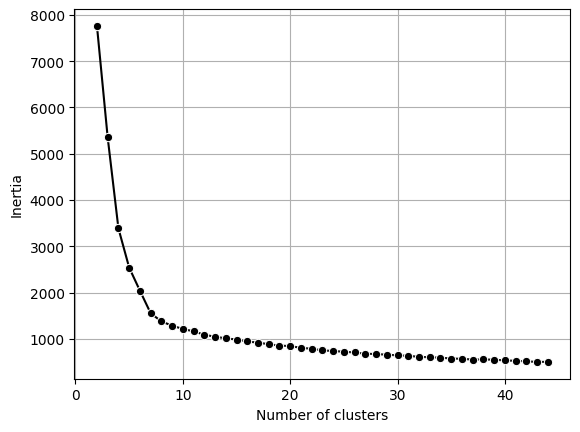

In [44]:
num_clusters = [i for i in range(2, 45)]

def kmeans_metrics(num_clusters, x_vals):
    '''
    Fits a KMeans model for different values of k.
    Calculates an inertia score for each k value.

    Args:
        num_clusters: (list of ints)  - The different k values to try
        x_vals:       (array)         - The training data

    Returns: 
        inertia:      (list)          - A list of inertia scores, one for each \
                                      value of k
    '''

    inertia = []
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score, inertia

sil_score, inertia = kmeans_metrics(num_clusters, X_scaled)

# Create an elbow plot
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o',color = 'black', markersize=6)
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");
plot.grid()
plt.show()

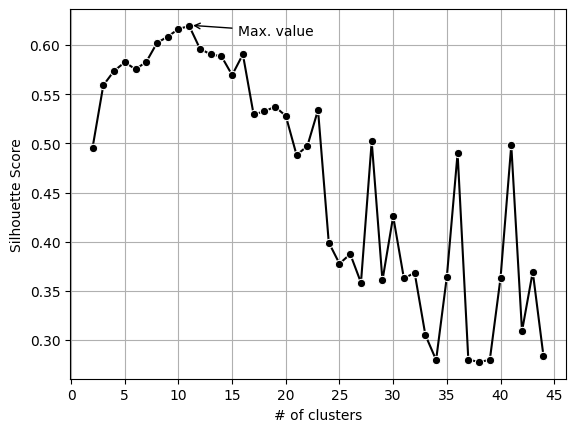

In [45]:
# Create a line plot of silhouette scores 
plot = sns.lineplot(x=num_clusters, y=sil_score,marker = 'o',color = 'black', markersize=6)
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");
plot.set_xticks(np.arange(0,50,5))
plot.annotate('Max. value',(11.1,0.62), xytext=(15.5,0.61),

            arrowprops=dict(arrowstyle="->")) 
plot.grid()

plt.show()

The elbow method did not show a clear point for the number of clusters. With the silhouette method, the maximum value occurred with 11 clusters. Let's see the centroids of these 11 clusters.

In [46]:
# Fit best number of clusters

kmeans= KMeans(n_clusters=11, random_state=42)

# Fit model to data
kmeans.fit(X_scaled)

centroids  = kmeans.cluster_centers_
centroids = pd.DataFrame(scaler.inverse_transform(centroids),columns = X.columns)

#Round Salary and promotion 
centroids[['promotion','salary_num']] = centroids[['promotion','salary_num']].round()
centroids.head(11)

,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,promotion,salary_num
0,0.507727,0.720000,4.045455,244.636364,2.318182,0.0,1.0
1,0.107822,0.870198,6.198020,274.881188,4.095710,0.0,-0.0
2,0.808879,0.912804,4.574766,246.345794,5.191589,0.0,1.0
3,0.407344,0.512294,2.012072,143.915493,3.002012,0.0,0.0
4,0.492500,0.613750,3.000000,178.625000,3.375000,1.0,0.0
5,0.405750,0.510812,2.031250,144.631250,3.018750,0.0,1.0
6,0.812357,0.920808,4.548822,245.104377,5.215488,0.0,-0.0
7,0.113439,0.860000,6.180995,273.914027,4.158371,0.0,1.0
8,0.612093,0.875116,4.186047,178.767442,3.046512,0.0,0.0
9,0.497073,0.616585,3.853659,223.634146,3.975610,0.0,0.0


## Insights from the centroids

- Clusters 3, 5, and 10 only differ in terms of salaries. These employees are dissatisfied, have few projects, and work fewer hours. Cluster 10 was the only one with high salaries.
- Cluster 4 received promotions but still has low salaries compared to other clusters. They also have fewer projects and fewer monthly working hours.
- Clusters 2 and 6 are similar, except for salaries (medium and low). These groups have been with the company for a long time (tenure of 5 years), have good performance evaluations, and are satisfied with the company. However, their salaries are lower (low and medium).
- Clusters 1 and 7 also differ only in salary. They are extremely dissatisfied groups with many projects and long working hours.
- Cluster 8 shows little satisfaction with the company (0.6), good performance evaluations, but with less monthly working hours and lower salaries.
- For clusters 0 and 9, it is unclear what might be causing dissatisfaction. They have average performance evaluations and lower salaries. However, in terms of the number of projects and tenure, they are doing well.

## Recommendations

These clusters can be used to identify which group the worker belongs to and to find a more suitable strategy.

- For clusters 3, 4, 5, and 10, I would recommend involving these employees in more projects to increase their engagement with the company and level of satisfaction.
- Clusters 1 and 7 need a reduction in the number of projects and working hours. Better managerial work is needed to avoid overloading these employees.
- Clusters 2 and 6 are great employees who have been with the company for a long time. A salary increase could help retain them in the company.
- Cluster 8, with moderate satisfaction levels and higher performance evaluations, may benefit from career development opportunities and salary increases to improve retention.
- Cluster 0 and 9 would benefit from further investigation into what is making them dissatisfied. If they have good performance evaluations, perhaps higher salaries or other positions would help.

# paCe: Construct Stage

The next stage of the project involves creating different models to evaluate their effectiveness, limitations, and to improve our understanding of the problem.

The main objective is to create a machine learning model to predict employee turnover. The model is supervised and classification-based. Additionally, the categories are binary (left or not left). We will test logistic regression, decision tree, and other ensemble models.

### Modeling

Our main goal is to predict whether a worker is going to leave the company. While false negatives have a higher business impact, false positives also have consequences as they may lead to unnecessary promotions. In that case, we will use the F1 score metric, as it considers both recall (to minimize false negatives) and precision (to minimize false positives).

First, let's remove the outliers discussed earlier and drop the salary variable, as we have already transformed it into numeric format in the "salary_num" variable.

In [47]:
### OneHotEncode:

#Drop Salary String
df_model = df.drop('salary',axis = 1)
df_model = pd.get_dummies(data = df_model, drop_first = True, columns=['department'])
df_model.head()

,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,work_accident,left,promotion,salary_num,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False


#### Data Split

The data is unbalanced with only 17% workers that left the company. If we split the data in 60% for training, 20% for validation and 20% for test, we would have approximatelly 404 (20% x 11991 x 17%) positive cases for test and validation, which is a good amount of data.

In [48]:
#Separate the data: Unbalaced 83/17

X = df_model.drop('left',axis=1)
y = df_model['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)


print(X_tr.shape,X_test.shape, X_val.shape, y_tr.shape, y_test.shape, y_val.shape)

(7194, 17) (2399, 17) (2398, 17) (7194,) (2399,) (2398,)


## Logistic Regressions

#### Model 1: All Features

In [49]:
## Dropping Outliers for logistic regression

df_model_reg = df_model[df_model['tenure']<6]


#Train with all features

X = df_model_reg.drop(['left'],axis=1)
y = df_model_reg['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)

print(X_tr.shape,X_test.shape, X_val.shape, y_tr.shape, y_test.shape, y_val.shape)

clf1 = LogisticRegression(solver='liblinear')
clf1.fit(X_tr,y_tr)

(6699, 17) (2234, 17) (2234, 17) (6699,) (2234,) (2234,)


LogisticRegression(solver='liblinear')

In [50]:
pd.Series(clf1.coef_[0], index=X.columns).sort_values(key=abs,ascending = False)

satisfaction_level       -4.329303
work_accident            -1.565636
promotion                -1.226022
tenure                    1.093327
salary_num               -0.514986
num_project              -0.491326
department_RandD         -0.330448
department_support        0.149284
department_sales          0.147221
department_management    -0.122993
last_eval                -0.121846
department_technical      0.120508
department_marketing      0.106347
department_hr             0.083045
department_accounting    -0.036150
avg_montly_hours          0.003889
department_product_mng    0.002256
dtype: float64

In [51]:
y_preds_clf1 = clf1.predict(X_val)

print(f"Recall: {recall_score(y_val,y_preds_clf1):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_clf1):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_clf1):.4f}")
print(f"F1: {f1_score(y_val,y_preds_clf1):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_clf1):.4f}")

Recall: 0.2447
Accuracy: 0.8250
Precision: 0.4623
F1: 0.3200
AUC: 0.5935


In [52]:
#Create table to account metrics for each model

columns = ['model_name','recall','accuracy','precision','f1','auc']
table_metrics = pd.DataFrame(columns= columns)

model_metrics = ['clf1', recall_score(y_val,y_preds_clf1),accuracy_score(y_val,y_preds_clf1), precision_score(y_val,y_preds_clf1), f1_score(y_val,y_preds_clf1), roc_auc_score(y_val,y_preds_clf1)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

In our initial model, we achieved a low recall (0.24) and moderate precision (0.46). Despite the high accuracy, it's important to note that the data is imbalanced. The satisfaction level appeared to be the most relevant feature based on the coefficients, but this information is limited as the features were not scaled. 

To improve the model, let's incorporate the centroids obtained from the K-means clustering algorithm.

#### Model 2: Using Feature Engineering

In [53]:
# Add the centroids to the DF

X = df_model_reg[['satisfaction_level','last_eval', 'num_project', 'avg_montly_hours', 'tenure', 'promotion', 'salary_num']]

X_scaled = scaler.fit_transform(X)
X_scaled[:2,:]

labels = kmeans.predict(X_scaled)
df_model_reg.loc[:,'cluster'] = labels

cluster_distance = (kmeans.transform(X_scaled))
df_model_reg.loc[:,'cluster_distance'] = [min(dist) for dist in cluster_distance]

df_model_reg = pd.get_dummies(data = df_model_reg, drop_first = True, columns=['cluster'])


In [54]:
X = df_model_reg.drop(['left'],axis=1)
y = df_model_reg['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)

clf2 = LogisticRegression(solver='liblinear')
clf2.fit(X_tr,y_tr)

y_preds_clf2 = clf2.predict(X_val)

print(f"Recall: {recall_score(y_val,y_preds_clf2):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_clf2):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_clf2):.4f}")
print(f"F1: {f1_score(y_val,y_preds_clf2):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_clf2):.4f}")


model_metrics = ['clf2', recall_score(y_val,y_preds_clf2),accuracy_score(y_val,y_preds_clf2), precision_score(y_val,y_preds_clf2), f1_score(y_val,y_preds_clf2), roc_auc_score(y_val,y_preds_clf2)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.8590
Accuracy: 0.9454
Precision: 0.8240
F1: 0.8411
AUC: 0.9110


The addition of clustering significantly improved the model, with the recall reaching 0.86 and accuracy reaching 0.95. Consequently, this model achieved an F1 score of 0.84.

As simpler models can often be more robust, let's attempt to reduce the number of features used without compromising the performance metrics.

In [55]:
#Train with fewer features

X = df_model_reg[['satisfaction_level','tenure','promotion','cluster_1','cluster_2','cluster_3','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_distance']]
y = df_model_reg['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)

clf3 = LogisticRegression(solver='liblinear')
clf3.fit(X_tr,y_tr)

y_preds_clf3 = clf3.predict(X_val)

print(f"Recall: {recall_score(y_val,y_preds_clf3):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_clf3):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_clf3):.4f}")
print(f"F1: {f1_score(y_val,y_preds_clf3):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_clf3):.4f}")

model_metrics = ['clf3', recall_score(y_val,y_preds_clf3),accuracy_score(y_val,y_preds_clf3), precision_score(y_val,y_preds_clf3), f1_score(y_val,y_preds_clf3), roc_auc_score(y_val,y_preds_clf3)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.8750
Accuracy: 0.9436
Precision: 0.8064
F1: 0.8393
AUC: 0.9162


In [56]:
#Model 4
X = df_model_reg[['satisfaction_level','tenure','num_project','cluster_1','cluster_2','cluster_3','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_distance']]
y = df_model_reg['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)

clf4 = LogisticRegression(solver='liblinear')
clf4.fit(X_tr,y_tr)

y_preds_clf4 = clf4.predict(X_val)

print(f"Recall: {recall_score(y_val,y_preds_clf4):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_clf4):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_clf4):.4f}")
print(f"F1: {f1_score(y_val,y_preds_clf4):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_clf4):.4f}")

model_metrics = ['clf4', recall_score(y_val,y_preds_clf4),accuracy_score(y_val,y_preds_clf4), precision_score(y_val,y_preds_clf4), f1_score(y_val,y_preds_clf4), roc_auc_score(y_val,y_preds_clf4)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.8777
Accuracy: 0.9436
Precision: 0.8049
F1: 0.8397
AUC: 0.9173


We observed an improvement in all metrics by selecting only the satisfaction level and tenure features. However, it's worth noting that the information from the other metrics was incorporated into the clusters and distances. Removing the promotion feature did not affect the metrics.

Finally, to analyze which coefficients have the most impact on the model, let's normalize the input data.

In [57]:
#Train with only few features

scaler_2 = StandardScaler()

X1 = df_model_reg[['satisfaction_level','tenure','num_project','cluster_1','cluster_2','cluster_3','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_distance']]

X = scaler_2.fit_transform(X1)

y = df_model_reg['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)

clf5 = LogisticRegression(solver='liblinear')
clf5.fit(X_tr,y_tr)

y_preds_clf5 = clf5.predict(X_val)

print(f"Recall: {recall_score(y_val,y_preds_clf5):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_clf5):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_clf5):.4f}")
print(f"F1: {f1_score(y_val,y_preds_clf5):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_clf5):.4f}")

model_metrics = ['clf5', recall_score(y_val,y_preds_clf5),accuracy_score(y_val,y_preds_clf5), precision_score(y_val,y_preds_clf5), f1_score(y_val,y_preds_clf5),roc_auc_score(y_val,y_preds_clf5)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.8910
Accuracy: 0.9467
Precision: 0.8111
F1: 0.8492
AUC: 0.9245


In [58]:
#Creating feature importance
pd.Series(clf5.coef_[0], index=X1.columns).sort_values(key=abs,ascending = False)

cluster_distance     -2.891416
satisfaction_level   -2.785131
tenure                2.067943
cluster_7            -0.978736
cluster_9            -0.941842
cluster_1            -0.866663
cluster_2             0.272937
cluster_3             0.266864
cluster_6             0.243512
cluster_5             0.142401
num_project           0.094352
cluster_8            -0.030450
cluster_10           -0.026014
dtype: float64

## Logistic regression conclusion:

The initial model proved to be quite inefficient. There was a significant improvement when adding cluster distances, achieving recalls greater than 0.85 and F1 scores higher than 0.84!

The model with the best recall (0.89) and F1 score (0.85) used clusters, satisfaction level, tenure, and number of projects. Although logistic regression does not require data normalization, we achieved an improvement in the metrics by doing so.

Analyzing the coefficients of the best model, we observed that the distance between clusters and satisfaction level were the most impactful variables. Regarding clusters, groups 2 and 6 (with well-evaluated workers, with a lot of company tenure, but low salaries) had coefficients twice as large. This highlights the importance of recognizing such workers and considering possible promotions.

Finally, let's check if all assumptions for the logistic model is satisfied:


1) Outcome variable is categorical -> Checked!
2) Observations are independent of each other -> There is no reason for the observations to not be independent.
3) No severe multicollinearity among X variables
4) No extreme outliers -> Already removed
5) Linear relationship between each X variable and the logit of the outcome variable
6) Sufficiently large sample size -> We used 6699 data points for training.

Now, let's verify assumptions 3 and 5. For assumption 3, let's use Variance inflation factor 

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X1.columns #Using X1 to get columns name only
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X, i) for i in range(len(X1.columns))] 
  
display(vif_scores)

,Attribute,VIF Scores
0,satisfaction_level,2.181383
1,tenure,2.093862
2,num_project,1.748212
3,cluster_1,2.476730
4,cluster_2,2.270461
5,cluster_3,2.272565
6,cluster_5,2.146725
7,cluster_6,2.182569
8,cluster_7,2.424042
9,cluster_8,2.461070


There is no VIF>5 showing that there is no severe multicollinearity. For assumptions 5, let's calculate the correlation for these variables with the 

```logit(p) = log(p/(1-p))``` of the probabilities.

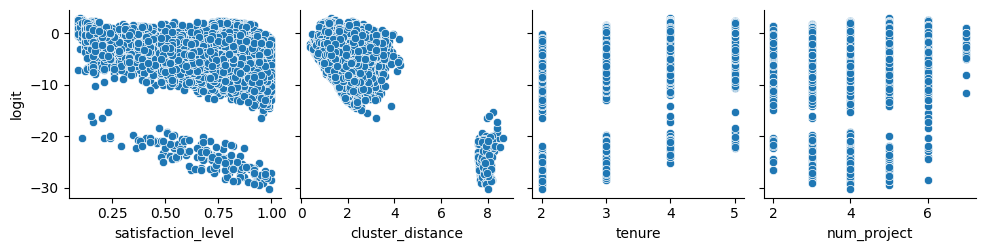

In [60]:
#Logit:

prob = clf5.predict_proba(X)[::,-1]
logit = np.log(prob/(1-prob))

X1['logit'] = logit

sns.pairplot(data=X1,y_vars='logit',x_vars = ['satisfaction_level','cluster_distance','tenure','num_project'])    
plt.show()

#Drop Logit
X1.drop('logit',axis=1,inplace=True)


It seems that there are two logit groups in the variables (in two tiers), but both tiers appear to be linear.

However, the linearity assumption doesn't seem to be strong for this model. Nevertheless, we obtained good results. Let's check the confusion matrix for this model to see a little further how its performs


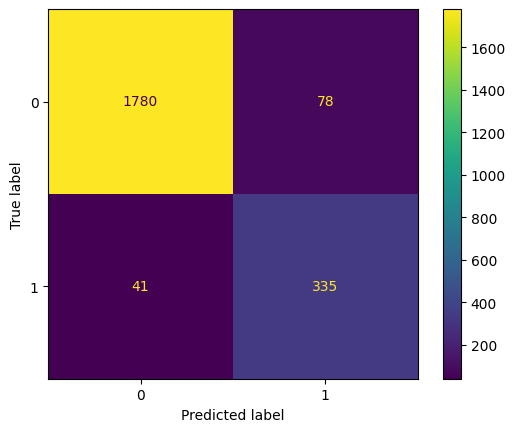

In [61]:

cm = confusion_matrix(y_val, y_preds_clf5, labels = clf5.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf5.classes_)

# Display the confusion matrix
disp.plot()
plt.show()


The upper-left quadrant shows the number of true negatives.
The upper-right quadrant shows the number of false positives.
The bottom-left quadrant shows the number of false negatives.
The bottom-right quadrant shows the number of true positives.

True negatives: 1780

False positives: 78

False negatives: 41

True positives: 335

This model predicted most instances correctly. Among the incorrect predictions, it forecasted that 78 workers would leave the company when they didn't, and 41 would stay when they actually left, indicating that when the model makes mistakes, it's more prone to type I errors (false positives).

Now, let's try fitting some more advanced machine learning models to see if the performance improves.

# Machine Learning Models

### Single Tree Model

First, we will start doing a hyperparameters tunning on the model to see which tree has better performance

In [62]:
#Split the data:


# Add the centroids to the DF

X = df_model[['satisfaction_level','last_eval', 'num_project', 'avg_montly_hours', 'tenure', 'promotion', 'salary_num']]

X_scaled = scaler.fit_transform(X)

labels = kmeans.predict(X_scaled)

df_model.loc[:,'cluster'] = labels

cluster_distance = (kmeans.transform(X_scaled))
df_model.loc[:,'cluster_distance'] = [min(dist) for dist in cluster_distance]

df_model = pd.get_dummies(data = df_model, drop_first = True, columns=['cluster'])



X = df_model.drop('left',axis=1)
y = df_model['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y, test_size=0.20)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state= 42, stratify = y_train, test_size=0.25)

tuned_decision_tree = DecisionTreeClassifier(random_state = 0)

# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[5,8,10,15,25,50],
             'min_samples_leaf': [2, 3, 5, 10],
             'max_features': [1,3,6,9,None]}

# Assign a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

Fitting the data:

In [63]:
%%time
# Instantiate the GridSearch
single_tree = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

# Fit the model
single_tree.fit(X_train, y_train)

print(f"Best Parameters:\n{single_tree.best_params_}")

Best Parameters:
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2}
CPU times: user 17.1 s, sys: 14.7 ms, total: 17.1 s
Wall time: 17.2 s


Plotting the best tree

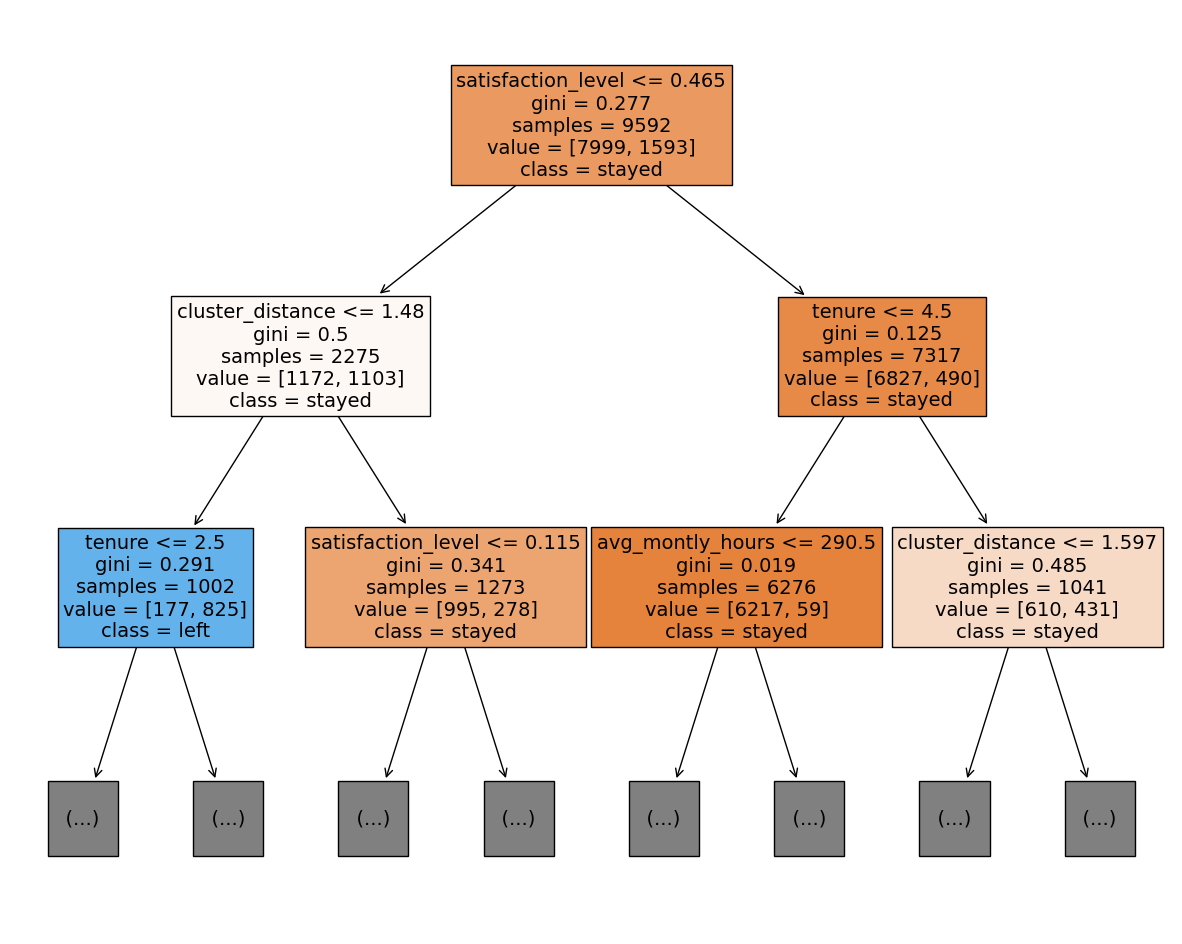

In [64]:
plt.figure(figsize=(15,12))
plot_tree(single_tree.best_estimator_, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

Now, let's see the importance of each feature.

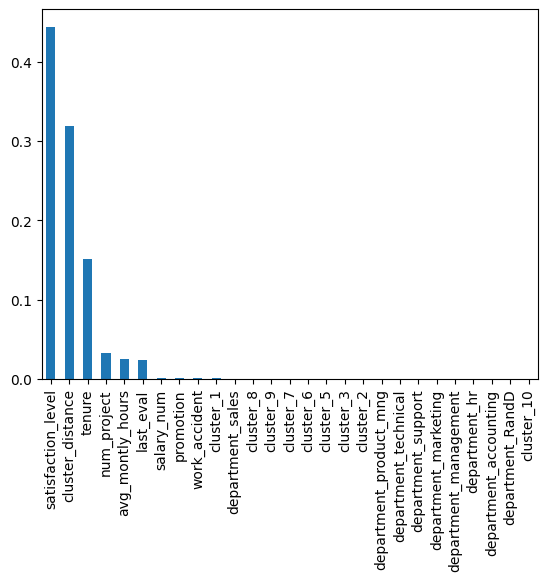

In [65]:
importances = single_tree.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);
plt.show()

And finally, let's calculate the metrics for this model.

In [66]:
y_preds_tree = single_tree.best_estimator_.predict(X_val)


print(f"Recall: {recall_score(y_val,y_preds_tree):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_tree):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_tree):.4f}")
print(f"F1: {f1_score(y_val,y_preds_tree):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_tree):.4f}")

model_metrics = ['single-tree', recall_score(y_val,y_preds_tree),accuracy_score(y_val,y_preds_tree), precision_score(y_val,y_preds_tree), f1_score(y_val,y_preds_tree),roc_auc_score(y_val,y_preds_tree)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.9372
Accuracy: 0.9875
Precision: 0.9868
F1: 0.9613
AUC: 0.9673


### Random Forest Model

In [67]:
rf = RandomForestClassifier(random_state=42)

#cv_params = {'max_depth': [2,4,10, None], 
#             'min_samples_leaf': [1,3,10,20],
#             'min_samples_split': [2,6,10,20],
#             'max_features': [2,3,4,10,'sqrt', 'log2', None],
#             'n_estimators': [25,75, 100, 125, 150]
#             }  

cv_params = {'max_depth': [None], 
             'min_samples_leaf': [1],
             'min_samples_split': [4],
             'max_features': [None],
             'n_estimators': [75]
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [68]:
%%time
rf_cv.fit(X_tr,y_tr)

CPU times: user 10.5 s, sys: 19.9 ms, total: 10.5 s
Wall time: 10.5 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [None],
                         'min_samples_leaf': [1], 'min_samples_split': [4],
                         'n_estimators': [75]},
             refit='f1', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [69]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 75}

In [70]:
y_preds_rf = rf_cv.best_estimator_.predict(X_val)


print(f"Recall: {recall_score(y_val,y_preds_rf):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_rf):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_rf):.4f}")
print(f"F1: {f1_score(y_val,y_preds_rf):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_rf):.4f}")

model_metrics = ['Random-Forest', recall_score(y_val,y_preds_rf),accuracy_score(y_val,y_preds_rf), precision_score(y_val,y_preds_rf), f1_score(y_val,y_preds_rf), roc_auc_score(y_val,y_preds_rf)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.9271
Accuracy: 0.9846
Precision: 0.9788
F1: 0.9523
AUC: 0.9616


## XGRBoost

In [71]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

cv_params = {'max_depth': [None], 
             'min_child_weight': [None,1],
             'learning_rate': [0.02,0.07, 0.1],
             'n_estimators': [75, 100, 125, 150]
             }    

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [72]:
%%time
xgb_cv.fit(X_tr, y_tr)

CPU times: user 1min 39s, sys: 1.01 s, total: 1min 40s
Wall time: 28.2 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.02, 0.07, 0.1],
                         'max_depth': [None], 'min_child_weight': [None, 1],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [73]:
print(f"Best Parameters:\n{xgb_cv.best_params_}")

Best Parameters:
{'learning_rate': 0.07, 'max_depth': None, 'min_child_weight': None, 'n_estimators': 125}


In [74]:
y_preds_xgb = xgb_cv.best_estimator_.predict(X_val)

print(f"Recall: {recall_score(y_val,y_preds_xgb):.4f}")
print(f"Accuracy: {accuracy_score(y_val,y_preds_xgb):.4f}")
print(f"Precision: {precision_score(y_val,y_preds_xgb):.4f}")
print(f"F1: {f1_score(y_val,y_preds_xgb):.4f}")
print(f"AUC: {roc_auc_score(y_val,y_preds_xgb):.4f}")

model_metrics = ['XGRBoost', recall_score(y_val,y_preds_xgb),accuracy_score(y_val,y_preds_xgb), precision_score(y_val,y_preds_xgb), f1_score(y_val,y_preds_xgb),roc_auc_score(y_val,y_preds_xgb)]

table_metrics = pd.concat([table_metrics,pd.DataFrame([model_metrics],columns = columns)], ignore_index=True)

Recall: 0.9271
Accuracy: 0.9850
Precision: 0.9814
F1: 0.9535
AUC: 0.9618


## Model selection and evaluation

Now that we create many models to predict the departure of workers, it's time to check which one is the best fit for us. Let's take a look on the metrics table

In [75]:
display(table_metrics)

,model_name,recall,accuracy,precision,f1,auc
0,clf1,0.244681,0.824978,0.462312,0.320000,0.593546
1,clf2,0.859043,0.945389,0.823980,0.841146,0.910953
2,clf3,0.875000,0.943599,0.806373,0.839286,0.916241
3,clf4,0.877660,0.943599,0.804878,0.839695,0.917301
4,clf5,0.890957,0.946732,0.811138,0.849176,0.924488
5,single-tree,0.937186,0.987490,0.986772,0.961340,0.967343
6,Random-Forest,0.927136,0.984570,0.978780,0.952258,0.961568
7,XGRBoost,0.927136,0.984987,0.981383,0.953488,0.961818


The model that performed best on the validation set for both F1 metric and overall metrics was the single decision tree model. However, this model has a high risk of overfitting the data. As the XGBoost model was only marginally worse (with an F1 score just 0.68% lower), we will choose this model. 

The hyperparameters that led to the highest metrics are:

- learning_rate = 0.07, 
- max_depth = None, 
- min_child_weight = None, 
- n_estimators = 125

Let's further evaluate the performance of this model by examining its confusion matrix.

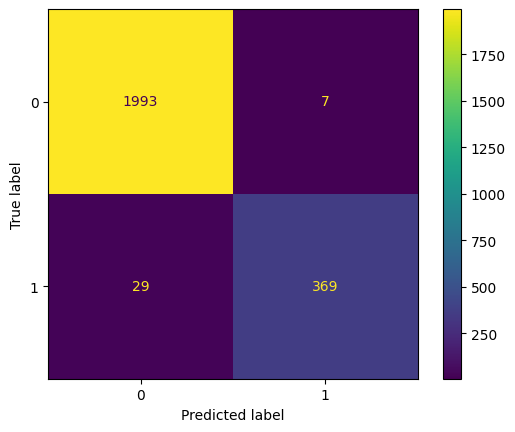

In [76]:
cm = confusion_matrix(y_val, y_preds_xgb, labels = xgb_cv.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = xgb_cv.classes_)

# Display the confusion matrix
disp.plot()
plt.show()

In the validation set, we had:

True negatives: 1994

False positives: 6

False negatives: 29

True positives: 369

The precision of our model for those who are not going to leave the company was (1994/(1994+6)) = 99.7%, while for those who are going to leave, it was (369/(369 + 29)) = 92.7%. Therefore, our model is slightly less (7% less) effective at recognizing workers who left. We can conduct a z-test and calculate the p-value. For this, we will use the following hypothesis test:

- H0: There is no difference in accuracy for the sample of workers who left the company and those who stayed.
- H1: There is a difference in accuracy between the samples.

In [77]:
num_neg = 369+29
num_pos = 1994+6
successes = [369, 1994]
nobs = [num_neg, num_pos]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z Statistic: {z_stat:.2f}')
print(f'P-Value: {pval:.1E}')
print(f'CI 95% for left group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for stay group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z Statistic: -10.61
P-Value: 2.6E-26
CI 95% for left group: [0.902, 0.953]
CI 95% for stay group: [0.995, 0.999]


With a p-value on the order of -26, we can reject the null hypothesis that the performance of our model is the same for both samples (those who left and those who stayed).

Another interesting detail in the model is the importance of each feature.

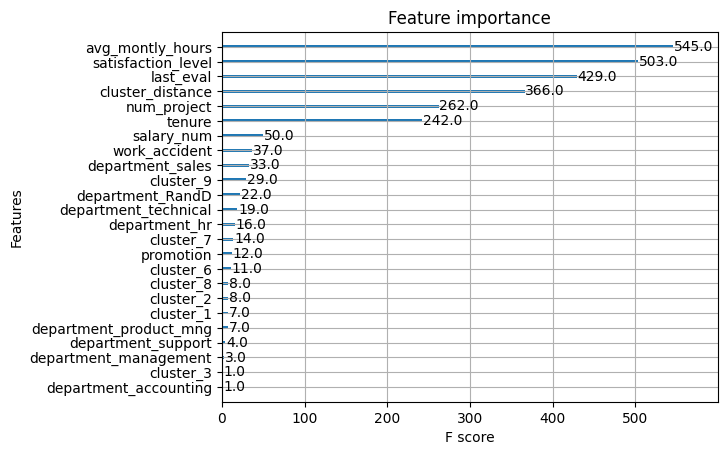

In [78]:
plot_importance(xgb_cv.best_estimator_);
plt.show()

In order of importance, the features that most impacted the model were the monthly working hours (indicating that worker overload is a decisive factor), the satisfaction level with the company, the last evaluation, the number of projects, and tenure. Salary, work accidents, or even the department seem to matter less.

Let's analyze how the model performed in relation to each cluster. To do this, we will use the feature dataset to add the target function and the value predicted by the model. We also need to add the clusters since we lost this information when using get_dummies.

In [79]:
## ADD cluster info
X_sample = X_tr[['satisfaction_level','last_eval', 'num_project', 'avg_montly_hours', 'tenure', 'promotion', 'salary_num']]

X_scaled = scaler.fit_transform(X_sample)

labels = kmeans.predict(X_scaled)

X_sample.loc[:,'cluster'] = labels

cluster_distance = (kmeans.transform(X_scaled))
X_sample.loc[:,'cluster_distance'] = [min(dist) for dist in cluster_distance]

In [80]:
##Add targets values to df

X_sample.loc[:,'left'] = y_tr
X_sample.loc[:,'left_predict'] = xgb_cv.best_estimator_.predict(X_tr)


X_left = X_sample[X_sample['left'] == 1]
X_left = X_sample[X_sample['left'] == 1]

## Check
print(f"\nCount of each cluster: \n{X_left['cluster'].value_counts()}")
print(f"\nPercentage of each cluster: \n{X_left['cluster'].value_counts(normalize=True)}")


Count of each cluster: 
cluster
3     295
1     194
5     190
6     173
2     140
7     137
9      27
8      20
10     12
0       7
Name: count, dtype: int64

Percentage of each cluster: 
cluster
3     0.246862
1     0.162343
5     0.158996
6     0.144770
2     0.117155
7     0.114644
9     0.022594
8     0.016736
10    0.010042
0     0.005858
Name: proportion, dtype: float64


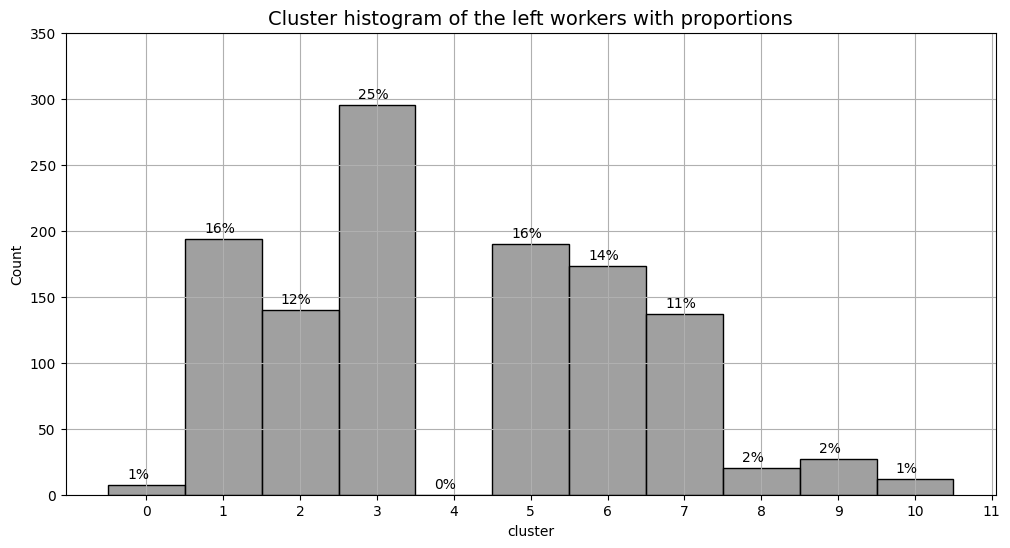

In [81]:
fig = plt.figure(figsize=(12,6))
sns.histplot(data = X_left, x = 'cluster', discrete=True, color = 'gray')
plt.xticks(range(12))
plt.yticks([i*50 for i in range(8)])
plt.grid()
plt.title("Cluster histogram of the left workers with proportions", fontsize = 14)

for i in range(11):
    filter_df = X_left[X_left['cluster'] == i]
    plt.annotate(f"{len(filter_df)/len(X_left)*100:.0f}%", (i-0.25,len(filter_df)+5))
    
plt.show()

We notice that we have very few samples in clusters 0, 4, 8, 9, and 10. There is a higher proportion of samples in clusters 3 and 5.

Let's analyze how the recall (which measures the model's ability to recognize positive cases) for each cluster to see how the model performed.

In [82]:
X_sample['test_label'] = ''
X_sample.reset_index(inplace=True)
for i in range(len(X_sample)):
    
    if (X_sample.loc[i,'left'] == 1) & (X_sample.loc[i,'left_predict'] == 1):
        X_sample.loc[i,'test_label'] = 'true_pos'
    
    elif (X_sample.loc[i,'left'] == 1) & (X_sample.loc[i,'left_predict'] == 0):
        X_sample.loc[i, 'test_label'] = 'false_neg'
    
    elif (X_sample.loc[i,'left'] == 0) & (X_sample.loc[i,'left_predict'] == 0):
        X_sample.loc[i,'test_label'] = 'true_neg'
    
    else:
        X_sample.loc[i,'test_label'] = 'false_pos'
        
columns_name = ['cluster','recall','all_true','true_positive']
cluster_df = pd.DataFrame(columns = columns_name)


for i in range(11):
    X_cluster = X_sample[X_sample['cluster']==i] 
    recall = recall_score(X_cluster['left'],X_cluster['left_predict'])        
    true_pos = len(X_cluster[X_cluster['test_label'] == 'true_pos'])
    false_neg = len(X_cluster[X_cluster['test_label'] == 'false_neg'])
    
    cluster_df = pd.concat( [ cluster_df, pd.DataFrame( [[i, recall , false_neg + true_pos, true_pos]], columns = columns_name  ) ] )

display(cluster_df)

,cluster,recall,all_true,true_positive
0,0,0.142857,7,1
0,1,0.932990,194,181
0,2,0.978571,140,137
0,3,0.986441,295,291
0,4,0.000000,0,0
0,5,0.968421,190,184
0,6,0.976879,173,169
0,7,0.941606,137,129
0,8,0.150000,20,3
0,9,0.222222,27,6


- The model performed very well for all clusters with a sufficient number of events. In the rarer cases (except for cluster 10), it performed poorly, with most of the predicted "positive" labels being false positives.

- It would be appropriate to retrain the model with the addition of new data including cases from clusters 0, 8, 9, and 10 as well, aiming to further optimize the model's performance.

- Cluster number 4 did not appear in the training sample.

- Since most of the errors were false positives in clusters 0, 8, and 9, it is recommended to ignore such cases and consider them all as not leaving the company.

# pacE: Execute Stage

In this stage, we will evaluate how the model performs on the test dataset, analyze the results, and propose improvement actions.

## Results with test sample

In [83]:
y_preds_xgb = xgb_cv.best_estimator_.predict(X_test)

print(f"Recall: {recall_score(y_test,y_preds_xgb):.4f}")
print(f"Accuracy: {accuracy_score(y_test,y_preds_xgb):.4f}")
print(f"Precision: {precision_score(y_test,y_preds_xgb):.4f}")
print(f"F1: {f1_score(y_test,y_preds_xgb):.4f}")
print(f"AUC: {roc_auc_score(y_test,y_preds_xgb):.4f}")

Recall: 0.9322
Accuracy: 0.9854
Precision: 0.9789
F1: 0.9550
AUC: 0.9641


Even in the test set, the model had a great performance, achieving an F1 score of 95.5%.

Let's analyze the confusion matrix generated by this sample to better understand the results.

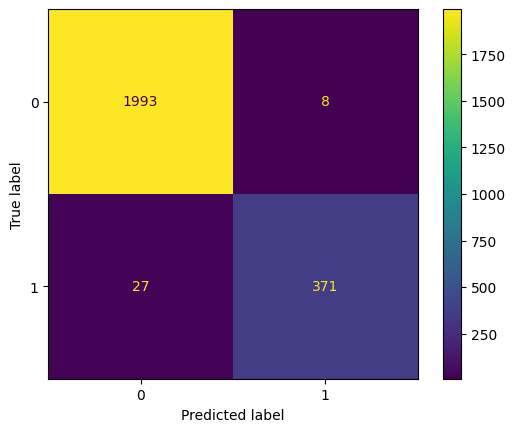

In [84]:
cm = confusion_matrix(y_test, y_preds_xgb, labels = xgb_cv.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = xgb_cv.classes_)

# Display the confusion matrix
disp.plot()
plt.show()

Similarly, the model generated more false negatives than false positives, indicating that it has more difficulty recognizing those who leave the company than those who stay. However, even for these people, we had an excellent accuracy.

We can see from the people who left which cluster they belonged to in order to look for any pattern.

In [85]:
X_sample = X_test[['satisfaction_level','last_eval', 'num_project', 'avg_montly_hours', 'tenure', 'promotion', 'salary_num']]


X_scaled = scaler.fit_transform(X_sample)

labels = kmeans.predict(X_scaled)

X_sample.loc[:,'cluster'] = labels

cluster_distance = (kmeans.transform(X_scaled))
X_sample.loc[:,'cluster_distance'] = [min(dist) for dist in cluster_distance]

X_sample.loc[:,'left'] = y_test
X_sample.loc[:,'left_predict'] = y_preds_xgb

X_sample.head()

,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,promotion,salary_num,cluster,cluster_distance,left,left_predict
11555,0.98,0.44,4,154,6,0,1,2,3.158102,0,0
27,0.40,0.49,2,135,3,0,0,3,1.242747,1,1
5890,0.30,0.67,3,232,3,0,0,9,1.824921,0,0
9098,0.96,0.52,4,228,3,0,0,9,1.423822,0,0
239,0.10,0.97,7,254,4,0,0,1,1.956021,1,1


In [86]:
X_left = X_sample[X_sample['left'] == 1]
X_left = X_sample[X_sample['left'] == 1]

X_left['cluster'].value_counts(normalize=True)

cluster
3     0.276382
5     0.170854
1     0.163317
6     0.130653
7     0.123116
2     0.075377
9     0.022613
10    0.015075
8     0.012563
0     0.010050
Name: proportion, dtype: float64

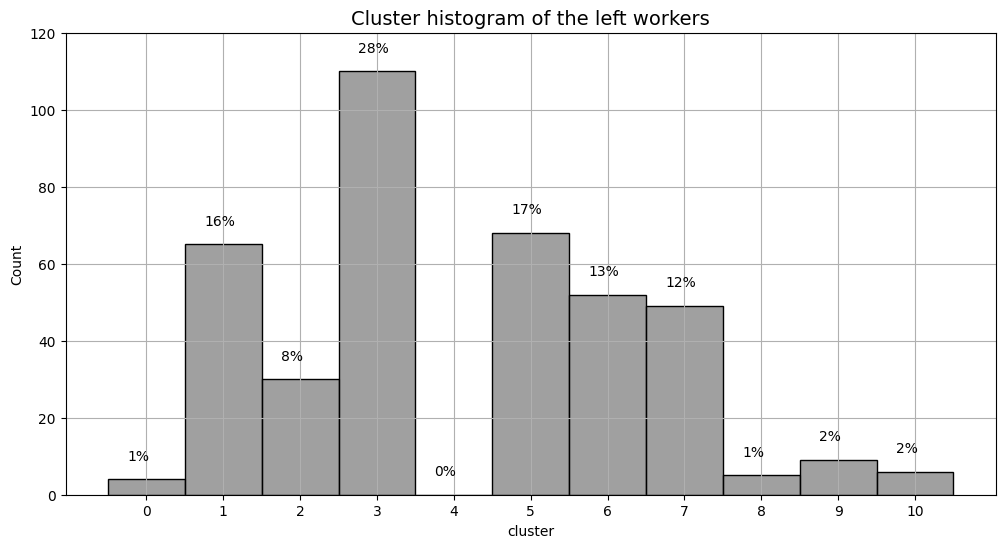

In [87]:
fig = plt.figure(figsize=(12,6))
sns.histplot(data = X_left, x = 'cluster', discrete=True, color = 'gray')
plt.xticks(range(11))
plt.yticks([i*20 for i in range(7)])
plt.grid()
plt.title("Cluster histogram of the left workers", fontsize = 14)

for i in range(11):
    filter_df = X_left[X_left['cluster'] == i]
    plt.annotate(f"{len(filter_df)/len(X_left)*100:.0f}%", (i-0.25,len(filter_df)+5))
    
plt.show()

For the test sample, 27% of the workers who left belong to cluster 3. Clusters 1, 3, 5, 6, and 7 had approximately 15% of the cases each. Cluster 2 accounts for 8%, while the others had very few cases. Cluster 4 didn't appear in the sample. This distribution is very similar to the one seen in the training sample. Therefore, the same conclusions apply.

Let's review the centroid data to better interpret these results.

In [88]:
display(centroids)

,satisfaction_level,last_eval,num_project,avg_montly_hours,tenure,promotion,salary_num
0,0.507727,0.720000,4.045455,244.636364,2.318182,0.0,1.0
1,0.107822,0.870198,6.198020,274.881188,4.095710,0.0,-0.0
2,0.808879,0.912804,4.574766,246.345794,5.191589,0.0,1.0
3,0.407344,0.512294,2.012072,143.915493,3.002012,0.0,0.0
4,0.492500,0.613750,3.000000,178.625000,3.375000,1.0,0.0
5,0.405750,0.510812,2.031250,144.631250,3.018750,0.0,1.0
6,0.812357,0.920808,4.548822,245.104377,5.215488,0.0,-0.0
7,0.113439,0.860000,6.180995,273.914027,4.158371,0.0,1.0
8,0.612093,0.875116,4.186047,178.767442,3.046512,0.0,0.0
9,0.497073,0.616585,3.853659,223.634146,3.975610,0.0,0.0


- Cluster 3, responsible for the majority of exits, is characterized by low salaries and few projects, and workers are dissatisfied with their jobs. They also have low performance ratings. They seem to be a group with low work motivation. According to the metrics, they appear to be underperforming workers (below-average ratings and few hours contributed). The company needs to find ways to motivate these employees. They could propose a career plan in which the employee could take on more projects and receive higher salaries if they perform well.

- Additionally, along with clusters 3, 5, and 10, which also have few projects and poor performance ratings, they account for 45.5% of the total exits.

- Clusters 1 and 7, on the other hand, account for 29% of cases and consist of workers with high workloads and project volumes. Here, it is necessary to improve the management of these people to understand why they are so overloaded.

- Clusters 2 and 6, which account for 21%, consist of workers with excellent performance ratings who are satisfied with their work but have lower salaries. These employees seem to be very valuable to the company and could therefore be considered for promotion or a raise.

- The other clusters account for less than 4% of cases.

# Conclusion, Recommendations, Next Steps
## EDA

In this project, an exploratory analysis of the human resources dataset was performed. The main findings were:

- Higher turnover rates are associated with employees who have 4 to 6 years of experience in the company. Specifically, employees with 4 years of experience, who also tend to have a lot of projects, left the company extremely dissatisfied.
- There is a balance between workload and job satisfaction. Employees with an appropriate workload tend to be more satisfied and less likely to leave the company, while those with either too few (2) or too many projects (6 or 7) are more likely to leave and are less satisfied with their job.
- High workloads lead to dissatisfaction and increased turnover rates. They are also not associated with higher salaries.
- There is a group of satisfied employees with a suitable workload who are leaving the company. This suggests they may be seeking better salaries elsewhere.
- Salaries do not significantly affect employee satisfaction levels but do impact turnover rates.
- The management department not only has lower turnover rates but also has the highest mean tenure at the company and receives more promotions, indicating higher job satisfaction and career growth opportunities in this department.
- Employees who were promoted in the last 5 years have lower turnover rates, suggesting that career advancement opportunities can significantly impact employee retention.

## K-means

After this initial contact with the dataset, a clustering model was created for the group of workers who left the company to find groups that would help us explain the reasons for the departures. Using the silhouette method, it was found that the optimal number of clusters was 11. The main findings of this analysis were:

- Clusters 3, 5, and 10 only differ in terms of salaries. These employees are dissatisfied, have few projects, and work fewer hours. Cluster 10 was the only one with high salaries.
- Cluster 4 received promotions but still has low salaries compared to other clusters. They also have fewer projects and fewer monthly working hours.
- Clusters 2 and 6 are similar, except for salaries (medium and low). These groups have been with the company for a long time (tenure of 5 years), have good performance evaluations, and are satisfied with the company. However, their salaries are lower (low and medium).
- Clusters 1 and 7 also differ only in salary. They are extremely dissatisfied groups with many projects and long working hours.
- Cluster 8 shows little satisfaction with the company (0.6), good performance evaluations, but with less monthly working hours and lower salaries.
- For clusters 0 and 9, it is unclear what might be causing dissatisfaction. They have average performance evaluations and lower salaries. However, in terms of the number of projects and tenure, they are doing well.

## Chosen Model

Finally, several models were created to find one that best suited business needs. The XGBoost model was chosen for having good results and being more robust than the single-tree model overall. Hyperparameter tuning was performed, and the hyperparameters that led to the highest metrics are:

- learning_rate = 0.07, 
- max_depth = None, 
- min_child_weight = None, 
- n_estimators = 125

Furthermore, the model can be used not only to recognize workers with the highest probability of leaving the company but also to understand the reasons for their departure (finding the nearest centroid to them). Furthermore, an improvement to the model would be to consider all clusters 0, 8, and 9 as workers who stay, as these were the cases where the model performed worst, with an excess of false positives.
## Recommendations

Applying the model to the test sample and analyzing the concentration of clusters, the following points are recommended for the company:

- Find ways to engage employees with few hours and projects. Especially those who are dissatisfied have a high tendency to leave the company. Perhaps involving them in more interesting/relevant projects would help.

- Improve the management of people with high working hours and a high number of projects. These are extremely dissatisfied individuals with high turnover rates.

- Reward good employees with good evaluations, who have been with the company for a long time, and are satisfied. There is a high turnover of workers with this profile with medium and low salaries. It would be interesting to evaluate possible promotions or salary increases.